# Heart Disease Diagnosis - A Classification Task

## The Problem

Identifying the presence of a condition in patients can be viewed as a classification task. A certain condition (heart disease, diabetes or cancer) is either **present (1)** in a patient or **absent (0)** from that patient. Since these are diagnostic tools, it is critically important to focus on **minimizing False Negatives**. We cannot build diagnostic tools that predict the **absence** of a condition when the ground truth is otherwise, an undiagnosed condition could delay treatment and be fatal to the patient. Since **False Negatives** are inversely proportional to **Recall**, our goal is to maximize the recall of our model.

## Importing the libraries

In [1]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

%matplotlib inline
shap.initjs()
plt.rcParams.update({'figure.figsize':(16, 9), 'figure.dpi':60})

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Importing the Data

In [2]:
# Moving up one level to /heart_disease
os.chdir('..')

In [3]:
# Data path is current dir + /heart.csv (// for windows machines)
DATA_PATH = os.getcwd() + '//'
fname = 'heart.csv'

In [4]:
# Read in the data
heart_df = pd.read_csv(DATA_PATH + fname, header = 'infer')
heart_df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5000,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4000,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8000,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6000,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4000,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3000,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0000,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5000,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6000,2,0,2,1


## The Data

The date is a modified version of the [UCI Heart Disease dataset](http://archive.ics.uci.edu/ml/datasets/heart+disease), also known as the Cleveland Dataset.

The `num` field refers to the presence of heart disease in the patient and is our **target** variable. It is derived from the `goal` variable in the original dataset, an integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish **presence** (values 1,2,3,4) from **absence** (value 0).

**Attribute Information:**

The 14 attributes used that make up this dataset: 
1. `age` : age in years 
2. `sex` : sex 
    * `1` : male
    * `0` : female 
3. `cp` : chest pain type 
    * `0` : typical angina 
    * `1` : atypical angina 
    * `2` : non-anginal pain 
    * `3` : asymptomatic
4. `trestbps` : resting blood pressure (in mm Hg on admission to the hospital) 
5. `chol` : serum cholestoral in mg/dl 
6. `fbs` : (fasting blood sugar > 120 mg/dl) 
    * `1` : true
    * `0` : false
7. `restecg` : resting electrocardiographic results 
    * `0` : normal 
    * `1` : having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    * `2` : showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. `thalach` : maximum heart rate achieved 
9. `exang` : exercise induced angina
    * `1` : yes
    * `0` : no
10. `oldpeak` : ST depression induced by exercise relative to rest 
11. `slope` : the slope of the peak exercise ST segment 
    * `1` : upsloping 
    * `2` : flat 
    * `3` : downsloping
12. `ca` : number of major vessels (0-3) colored by flourosopy 
13. `thal` : 
    * `3` : normal
    * `6` : fixed defect
    * `7` : reversable defect
14. `target` (**target**) : diagnosis of heart disease (angiographic disease status) 
    * `0` : < 50% diameter narrowing 
    * `1` : > 50% diameter narrowing

## Exploratory Data Analysis

In [5]:
# Check the column data types
heart_df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

While all of the 14 variables are encoded as numeric data, the following variables are categorical in nature : 
 *  `sex`
 *  `cp`
 *  `fbs`
 *  `restecg`
 *  `exang`
 *  `slope`
 *  `thal`
 *  `target`

In [6]:
# checking distribution of our target variable
heart_df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In our dataset, we have 303 examples, 165 (54%) show **presence** of heart disease. The dataset does show some slight imbalance in the class distribution (54/46) and we will take that into account when building our classification model.

Let us look at some plots to explore the visual relationships between the predictive features and the response. One way to get a better understanding of the data is to look at `age` and `sex` and ask the question, *What role do `age` and `sex` play in the prevalence of heart disease?*

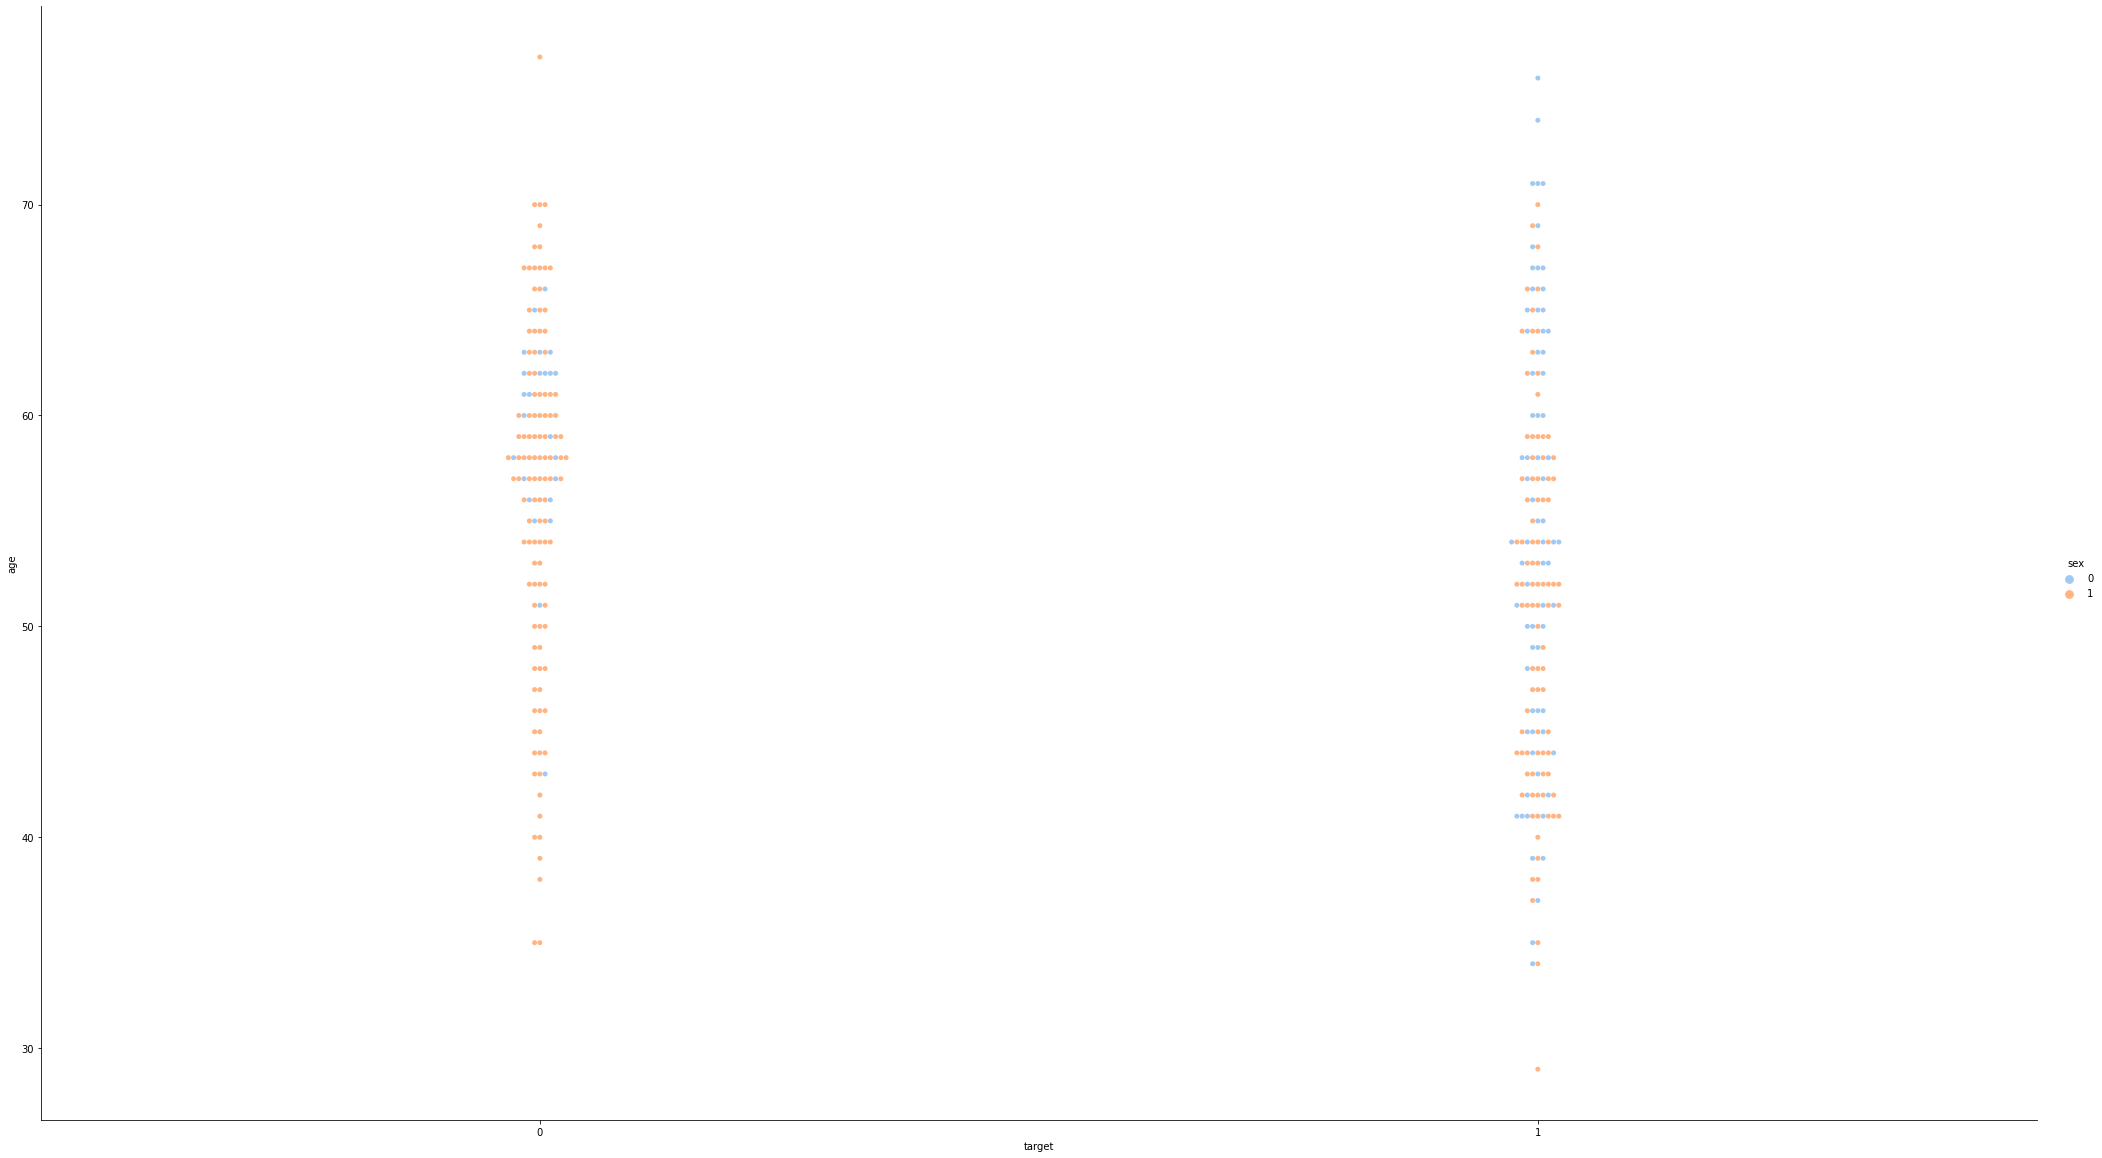

In [7]:
# Target distribution by age
sns.catplot(x="target", y="age", hue="sex", kind="swarm", data=heart_df, palette="pastel", height=16, aspect= 16/9);

The above graph is a categorical scatterplot which plots the `target` against `age` and `sex`. Since, this is a dataset where the majority class does have the disease, we can see that people who do have heart disease are well spread out across the `age` spectrum. `sex` on the other hand is a more interesting dimension. The minority class of people who do not have heart disease is dominated by men and has very few women (mostly women in their 50s or 60s), whereas the majority class has a more even spread. This may indicate that women may be more likely to have heart disease. We can explore that as follows : 

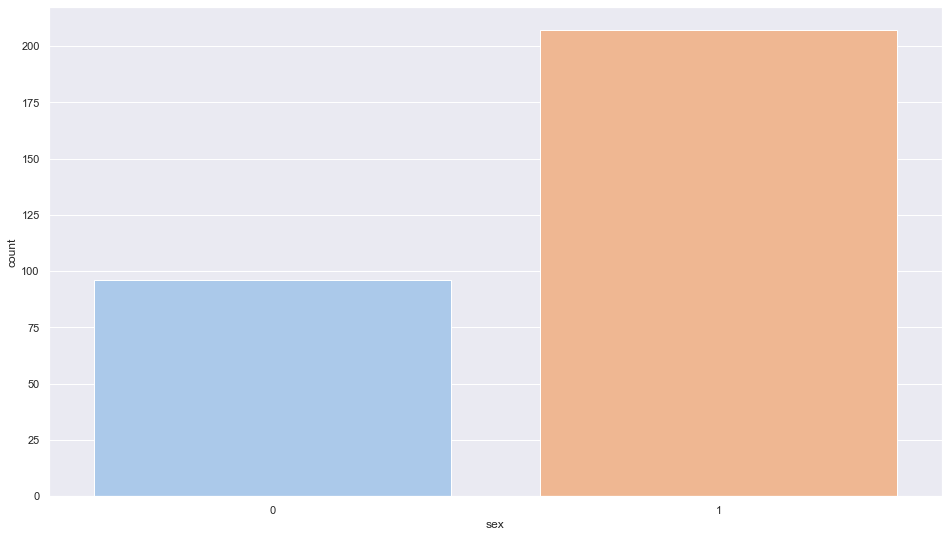

In [8]:
# Target distribution by sex
sns.set(rc={'figure.figsize':(16, 9)})
sns.countplot(x="sex", data=heart_df, palette="pastel");

Our dataset is skewed from a gender perspective. Men outnumber women by a ratio of 2:1. Because there is such a high number of men, it is no surprise that on first glance, they dominate the sub-population of people who do not have the disease. Let's explore further.

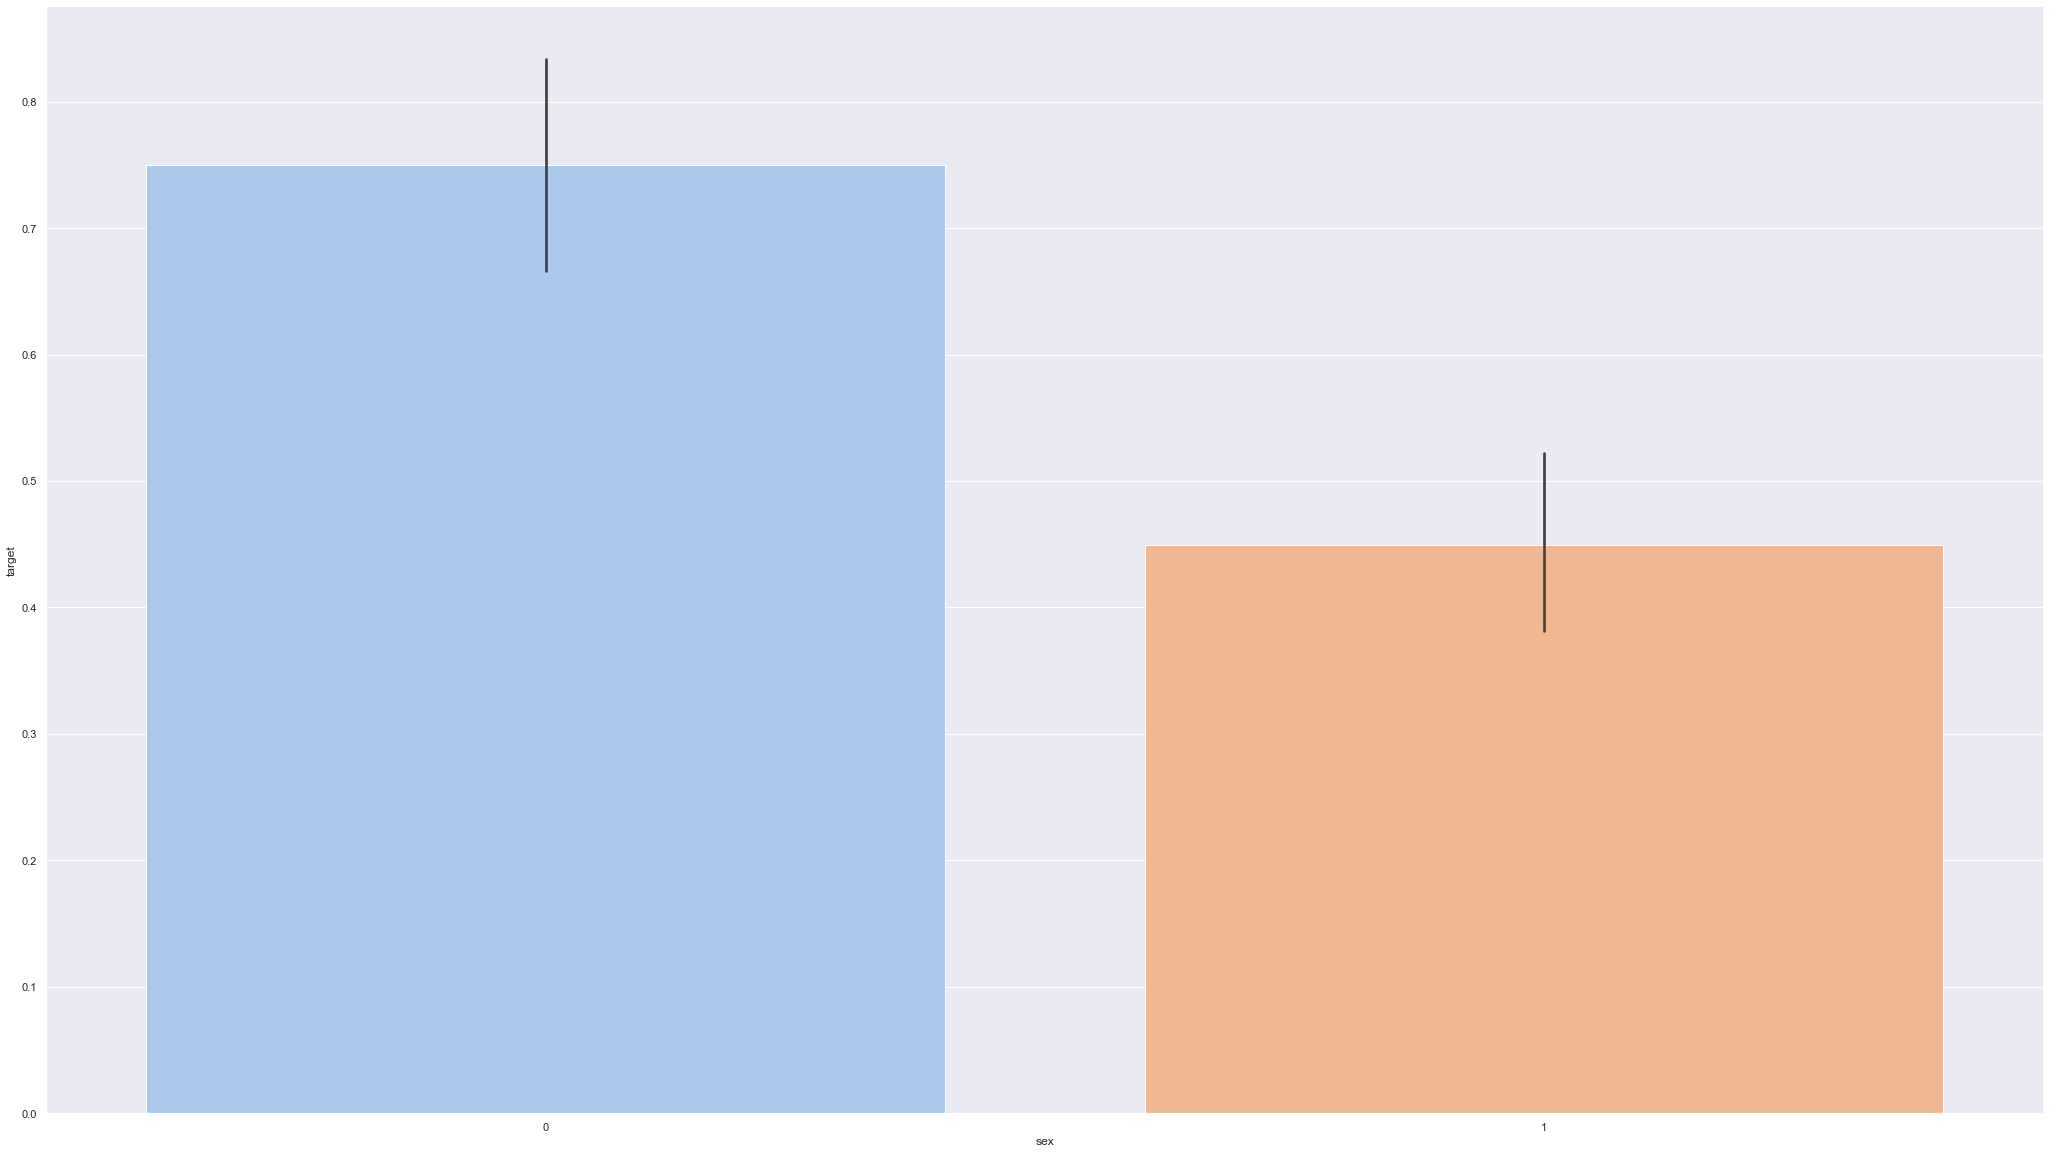

In [9]:
sns.catplot(x="sex", y="target", kind="bar", data=heart_df, palette="pastel", height=16, aspect= 16/9);

As we can clearly see here, having `sex == 1` seems to imply a lower chance of having heart disease.

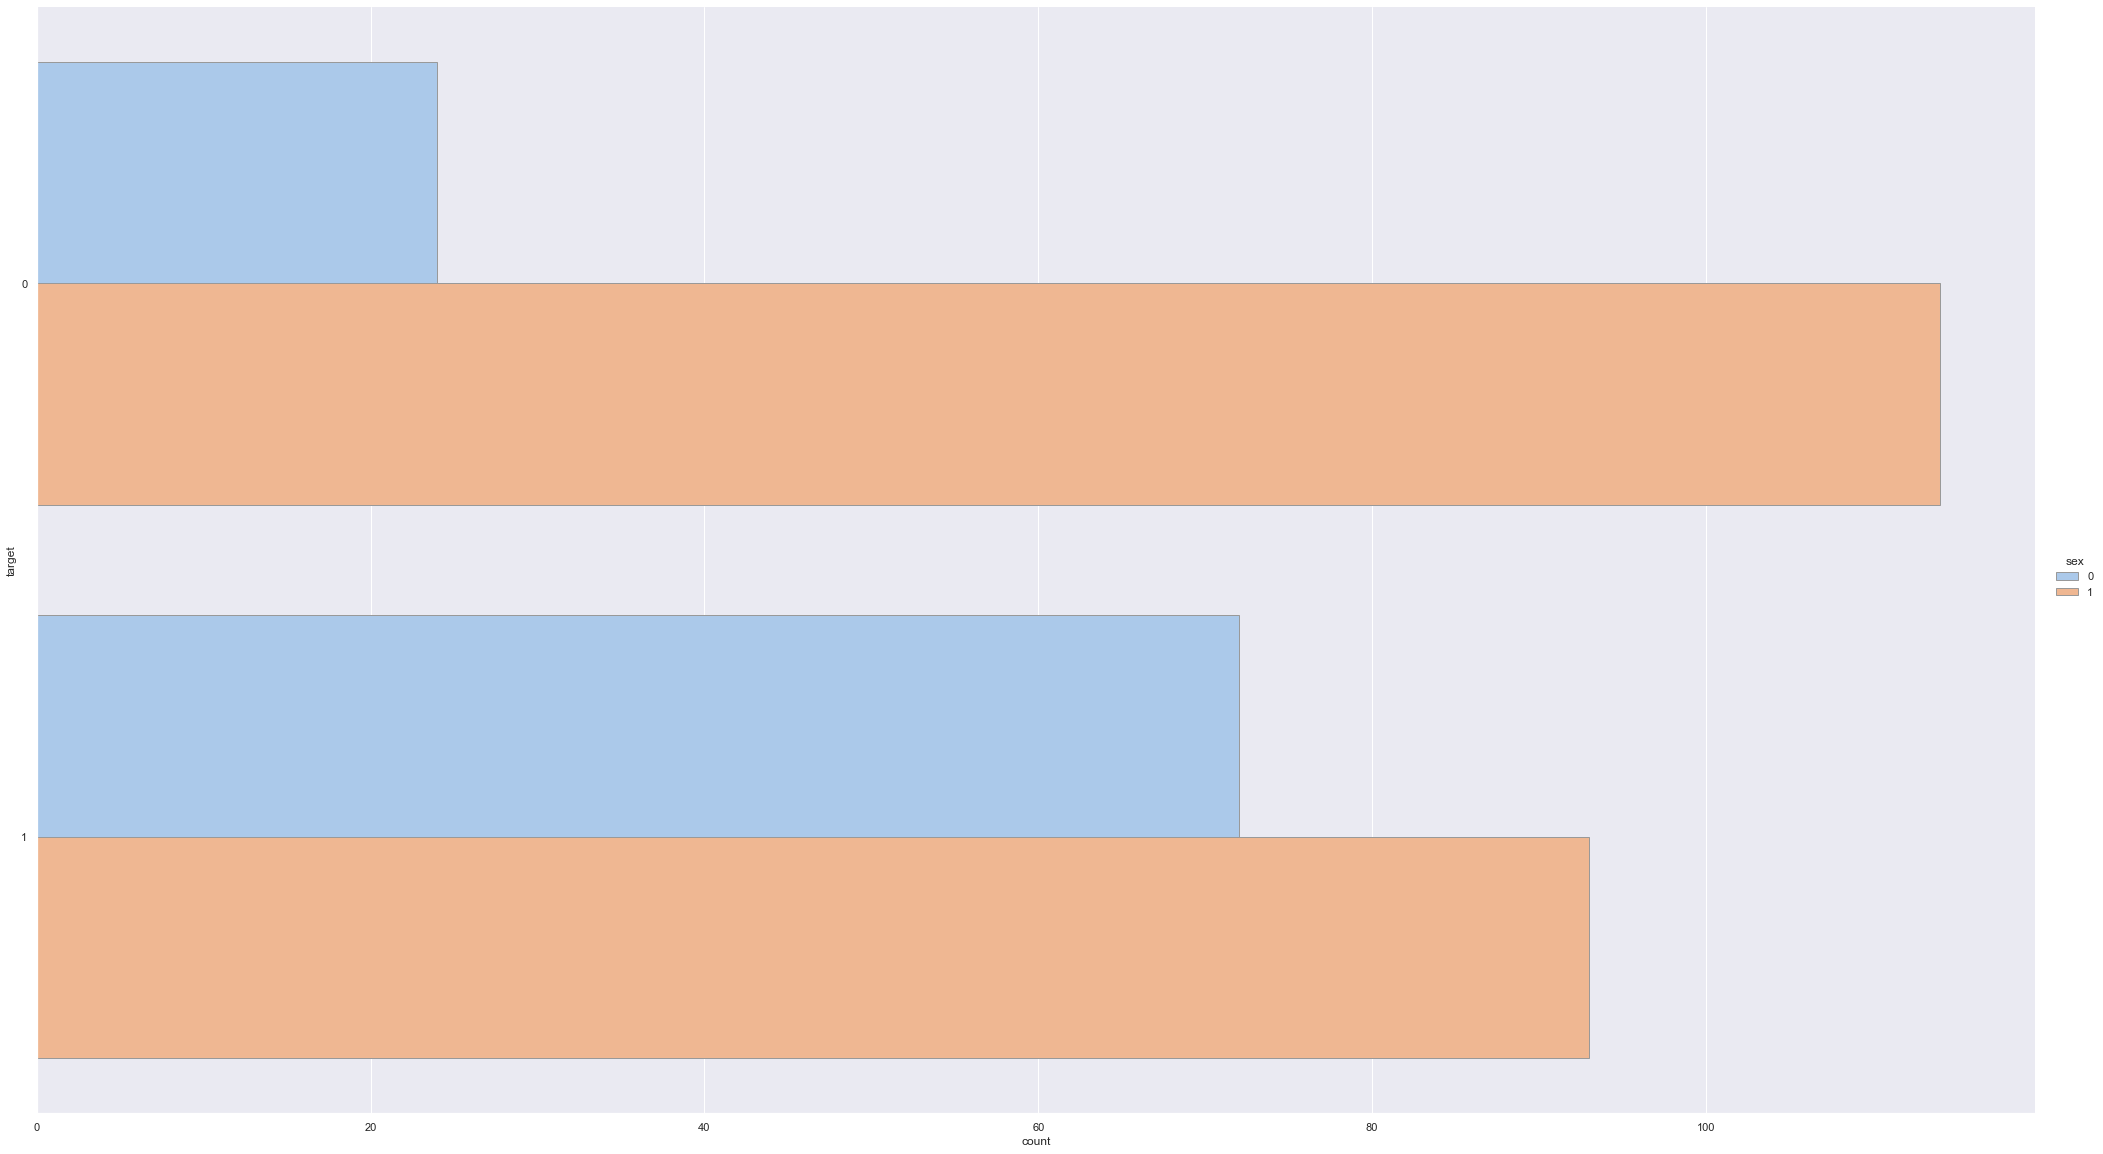

In [10]:
sns.catplot(y="target", hue="sex", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

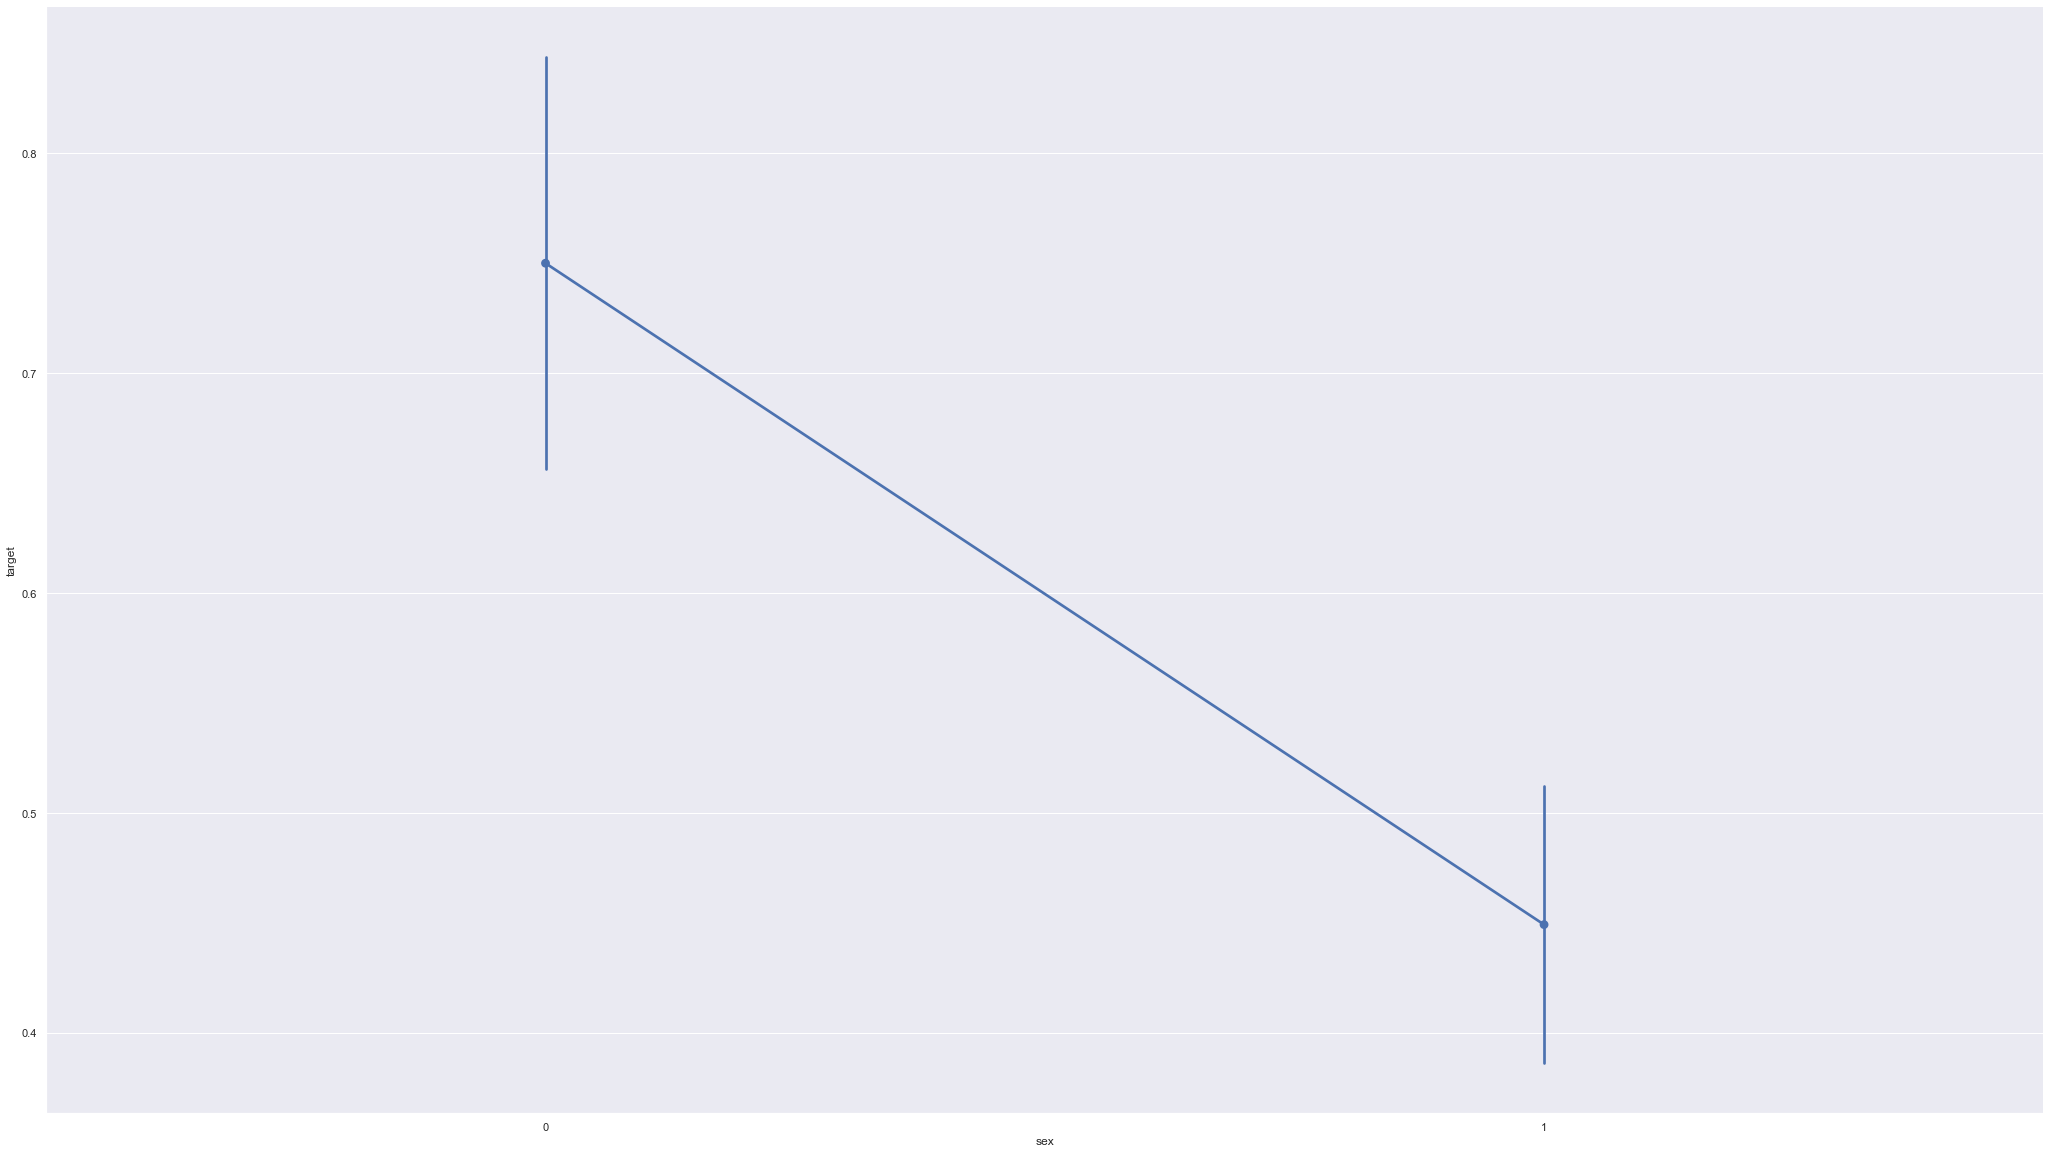

In [11]:
sns.catplot(x="sex", y="target", kind="point", data=heart_df, height=16, aspect= 16/9);

The sub-population of people who do not have the disease (`target == 0`) is dominated by men. Interestingly, the sub-population of people who do have the disease is also dominated by men. As we have seen before, men outnumber women by 2:1 in this dataset. To have a fair comparison between the two sub-populations we must look at incidence rates of the disease in the 2 sub-populations.

In [12]:
# incidence rate of heart disease == 1 by gender

## number of men with the disease/number of men
df_men = heart_df[heart_df['sex'] == 1]
print("Incidence :: Men ->", df_men[df_men['target'] == 1].shape[0]/df_men.shape[0])

## number of women with the disease/number of women
df_women = heart_df[heart_df['sex'] == 0]
print("Incidence :: Women ->", df_women[df_women['target'] == 1].shape[0]/df_women.shape[0])

Incidence :: Men -> 0.4492753623188406
Incidence :: Women -> 0.75


The above snippet quite clearly shows that the Incidence of heart disease for women in our sample is higher than that for men. This may be because of **Bias** as women are under-represented in our data. The only solution to this problem is to have a more gender balanced dataset. Otherwise our machine will end up learning that 75% of women have heart disease, which is inherently incorrect. Such biases can reduce trust in critical diagnostic tools and must be rectified.

Let us explore the important features of **blood pressure** (`trestbps`), **cholesterol** (`chol`) and **blood sugar** (`fbs`) and see what impact they have on the absence or presence of heart disease. 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


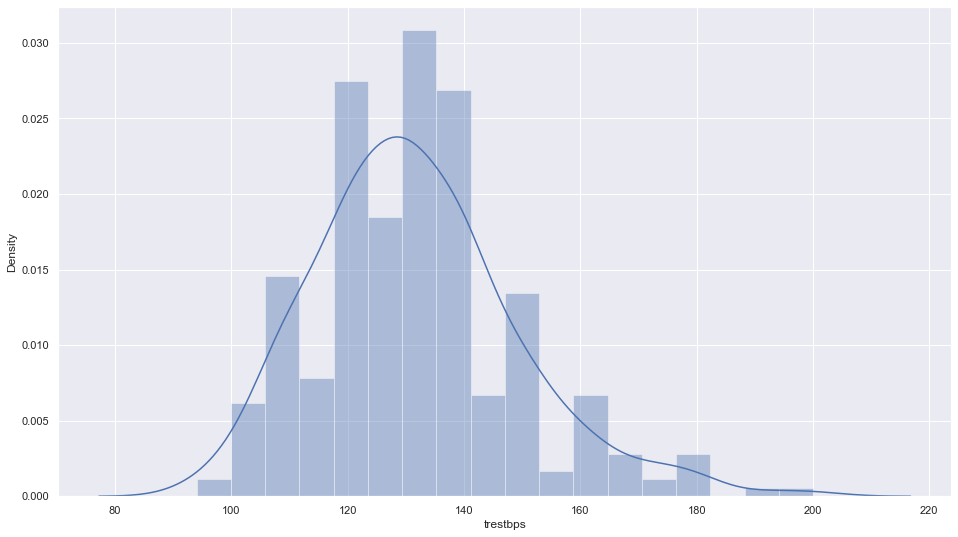

In [13]:
sns.distplot(heart_df['trestbps']);

At first glance, the blood pressure seems to be normally distributed, let us separate this out by `target`

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.


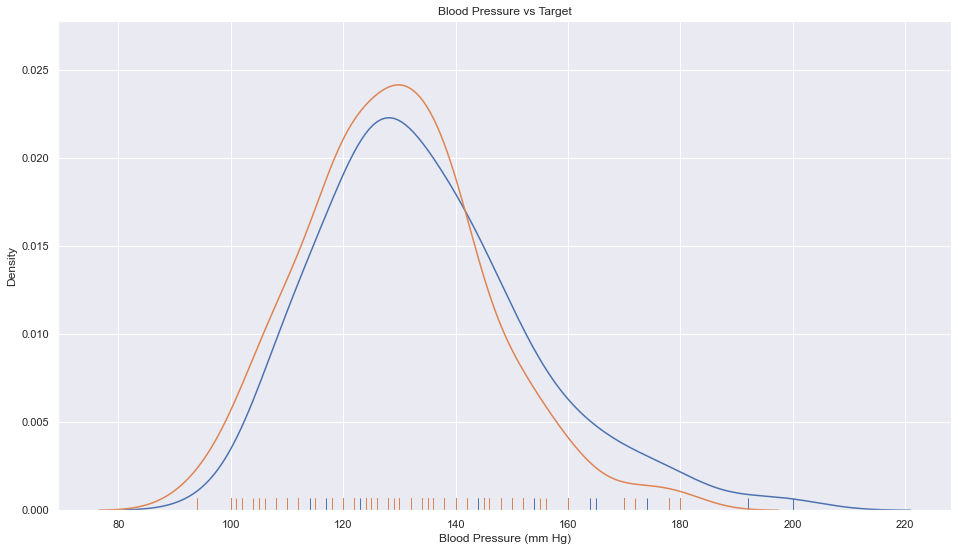

In [14]:
## Without heart disease
df_hd0 = heart_df[heart_df['target'] == 0]

## With heart disease
df_hd1 = heart_df[heart_df['target'] == 1]

## Blood pressure distribution by target
sns.distplot(df_hd0['trestbps'], hist=False, rug=True, label = 'Without Heart Disease')
sns.distplot(df_hd1['trestbps'], hist=False, rug=True, label = 'With Heart Disease')
plt.title('Blood Pressure vs Target')
plt.xlabel('Blood Pressure (mm Hg)')
plt.ylabel('Density');

The blood pressure is not able to separate our target classes, in fact, people with higher levels of blood pressure, don't seem to have heart disease at all. Let us explore `chol` in a similar manner.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.


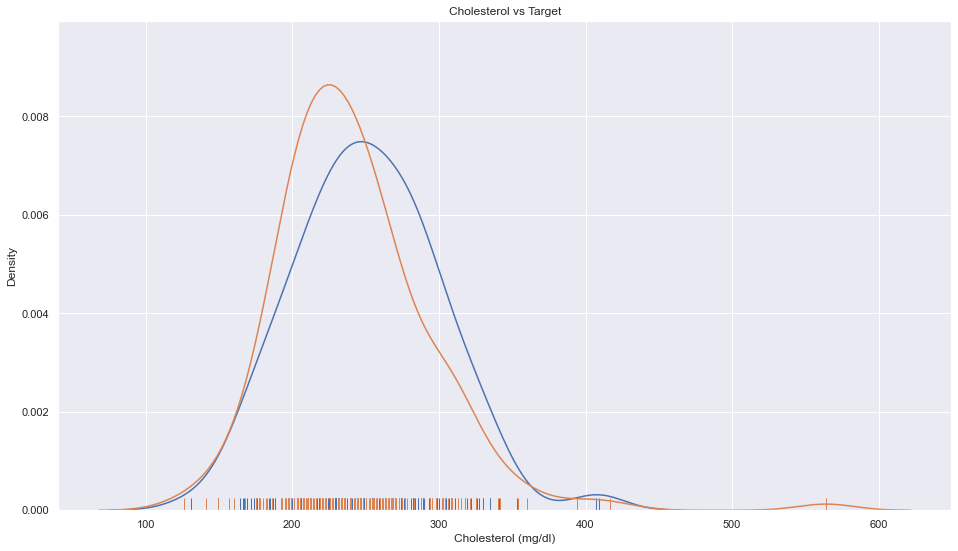

In [15]:
## Cholesterol distribution by target

sns.distplot(df_hd0['chol'], hist=False, rug=True, label = 'Without Heart Disease')
sns.distplot(df_hd1['chol'], hist=False, rug=True, label = 'With Heart Disease')
plt.title('Cholesterol vs Target')
plt.xlabel('Cholesterol (mg/dl)')
plt.ylabel('Density');

For people with heart disease, the right hand side tail is much longer and even has a small peak, implying that higher cholesterol levels do play a role in heart disease.

Let us now explore the impact of blood sugar (`fbs`) on heart disease. Unlike `chol` and `trestbps`, `fbs` is categorical, with `< 120 mg/dl == 0` and `> 120 mg/dl == 1`. **120 mg/dl** is a well known cutoff, consistently having blood sugar higher than this cutoff implies a person is [diabetic](https://en.wikipedia.org/wiki/Type_2_diabetes#Diagnosis).

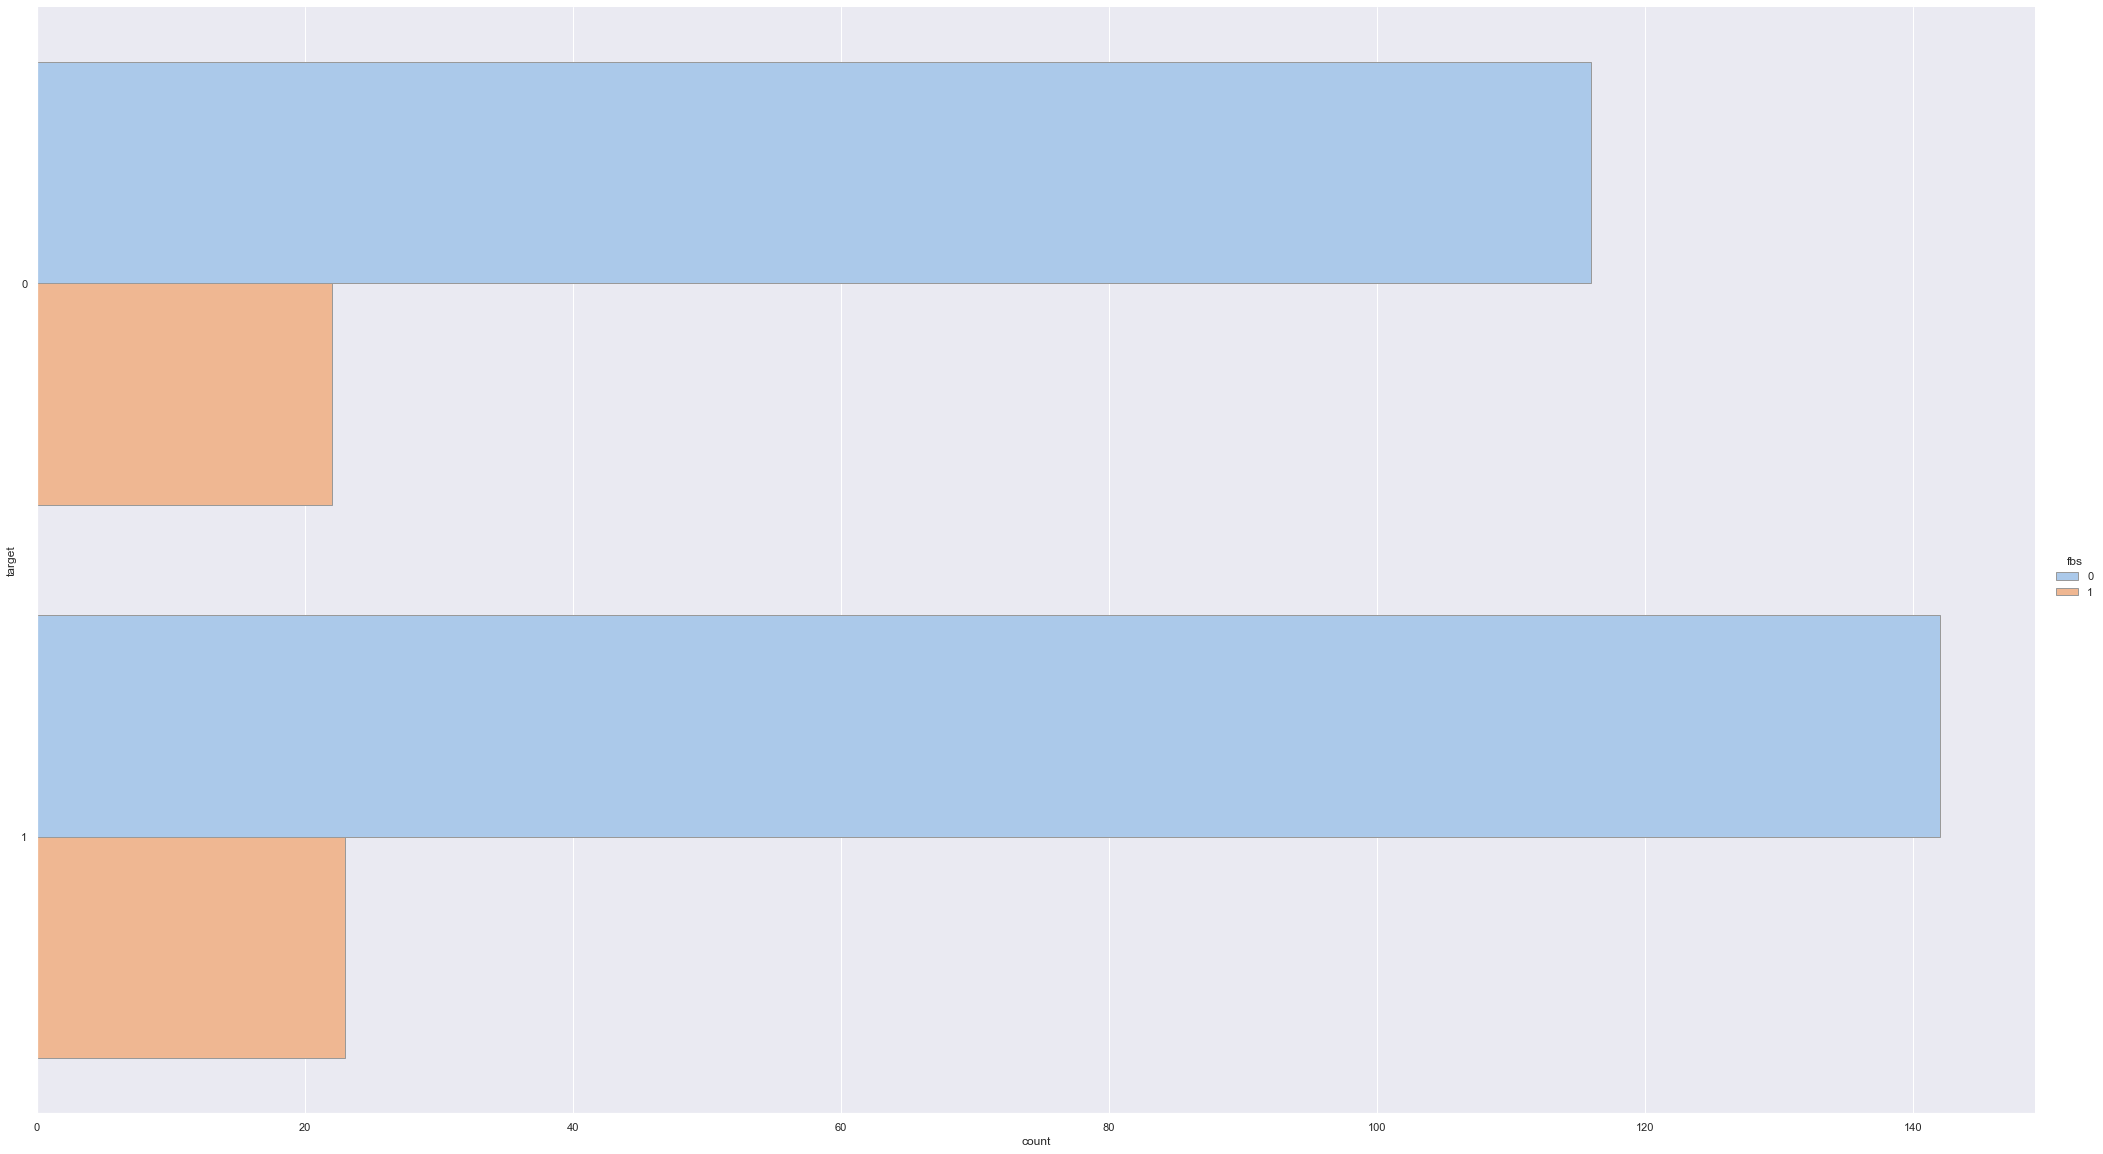

In [16]:
## Blood sugar distribution by target

sns.catplot(y="target", hue="fbs", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

Unfortunately, this plot doesn't help us differentiate whether being diabetic has any impact on the presence of heart disease, we will once again have to consider the incidence rates of both classes with respect to the presence of heart disease.

In [17]:
##incidence rates by blood sugar

df_fbs0 = heart_df[heart_df['fbs'] == 0]
## number of people with fbs0 with the disease/number of people with fbs0
print("Incidence :: FBS 0 ->", df_fbs0[df_fbs0['target'] == 1].shape[0]/df_fbs0.shape[0])
df_fbs1 = heart_df[heart_df['fbs'] == 1]
## number of people with fbs1 with the disease/number of people with fbs1
print("Incidence :: FBS 1 ->", df_fbs1[df_fbs1['target'] == 1].shape[0]/df_fbs1.shape[0])

Incidence :: FBS 0 -> 0.5503875968992248
Incidence :: FBS 1 -> 0.5111111111111111


The incidence rates for people with both classes of blood sugar is similar and around 50%, implying that `fbs` is not a large contributor to the presence of heart disease.

Let us similarly look at chest pain (`cp`) and `exang`, 2 more categorical variables related to angina (chest pain due to lack of blood flow to the heart).

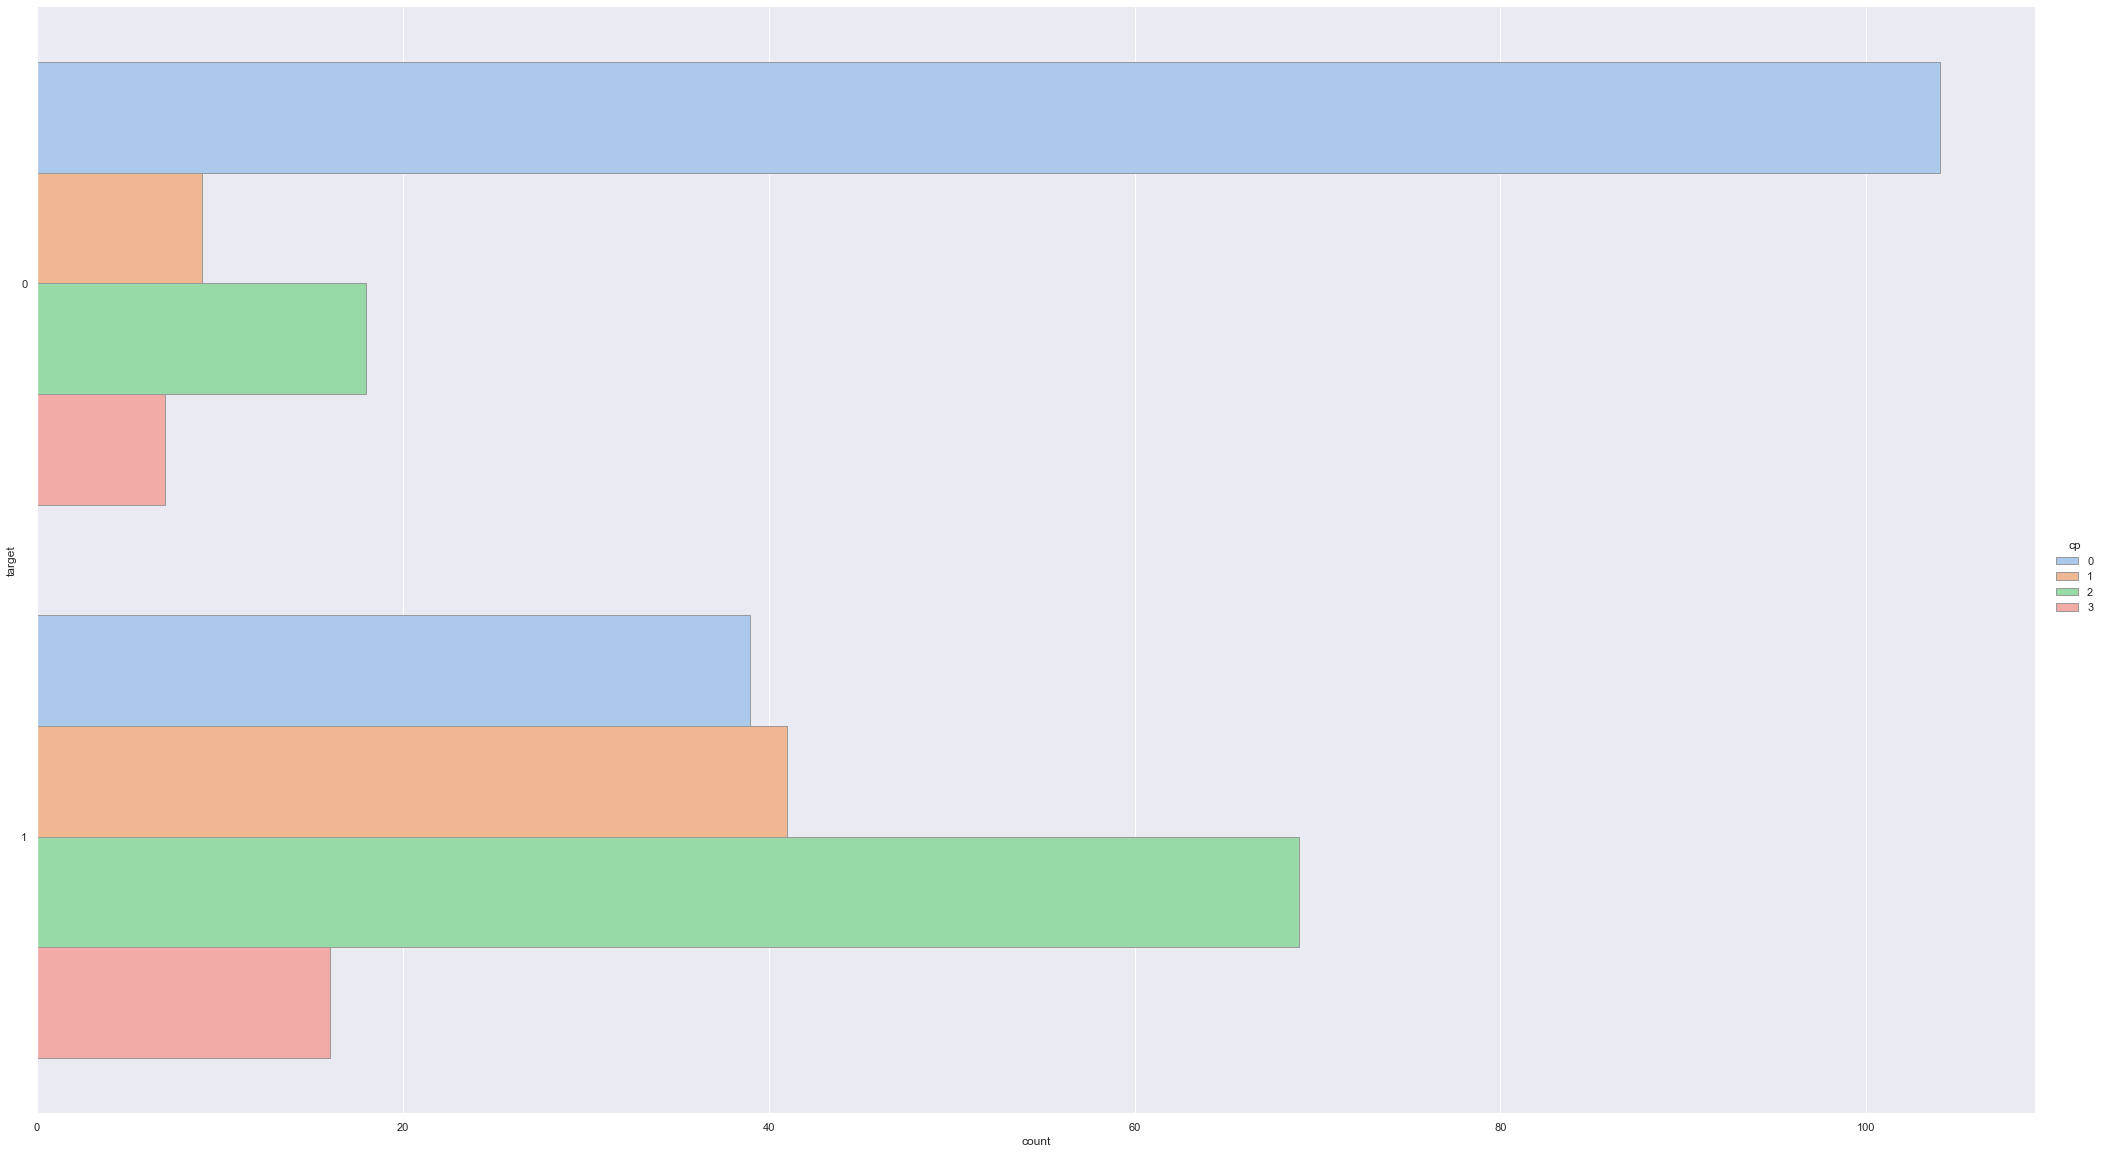

In [18]:
sns.catplot(y="target", hue="cp", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

Quite clearly, people who have chest pain of the types $1$, $2$ and $3$ have a greater likelihood of having heart disease than people who have chest pain of type $0$.

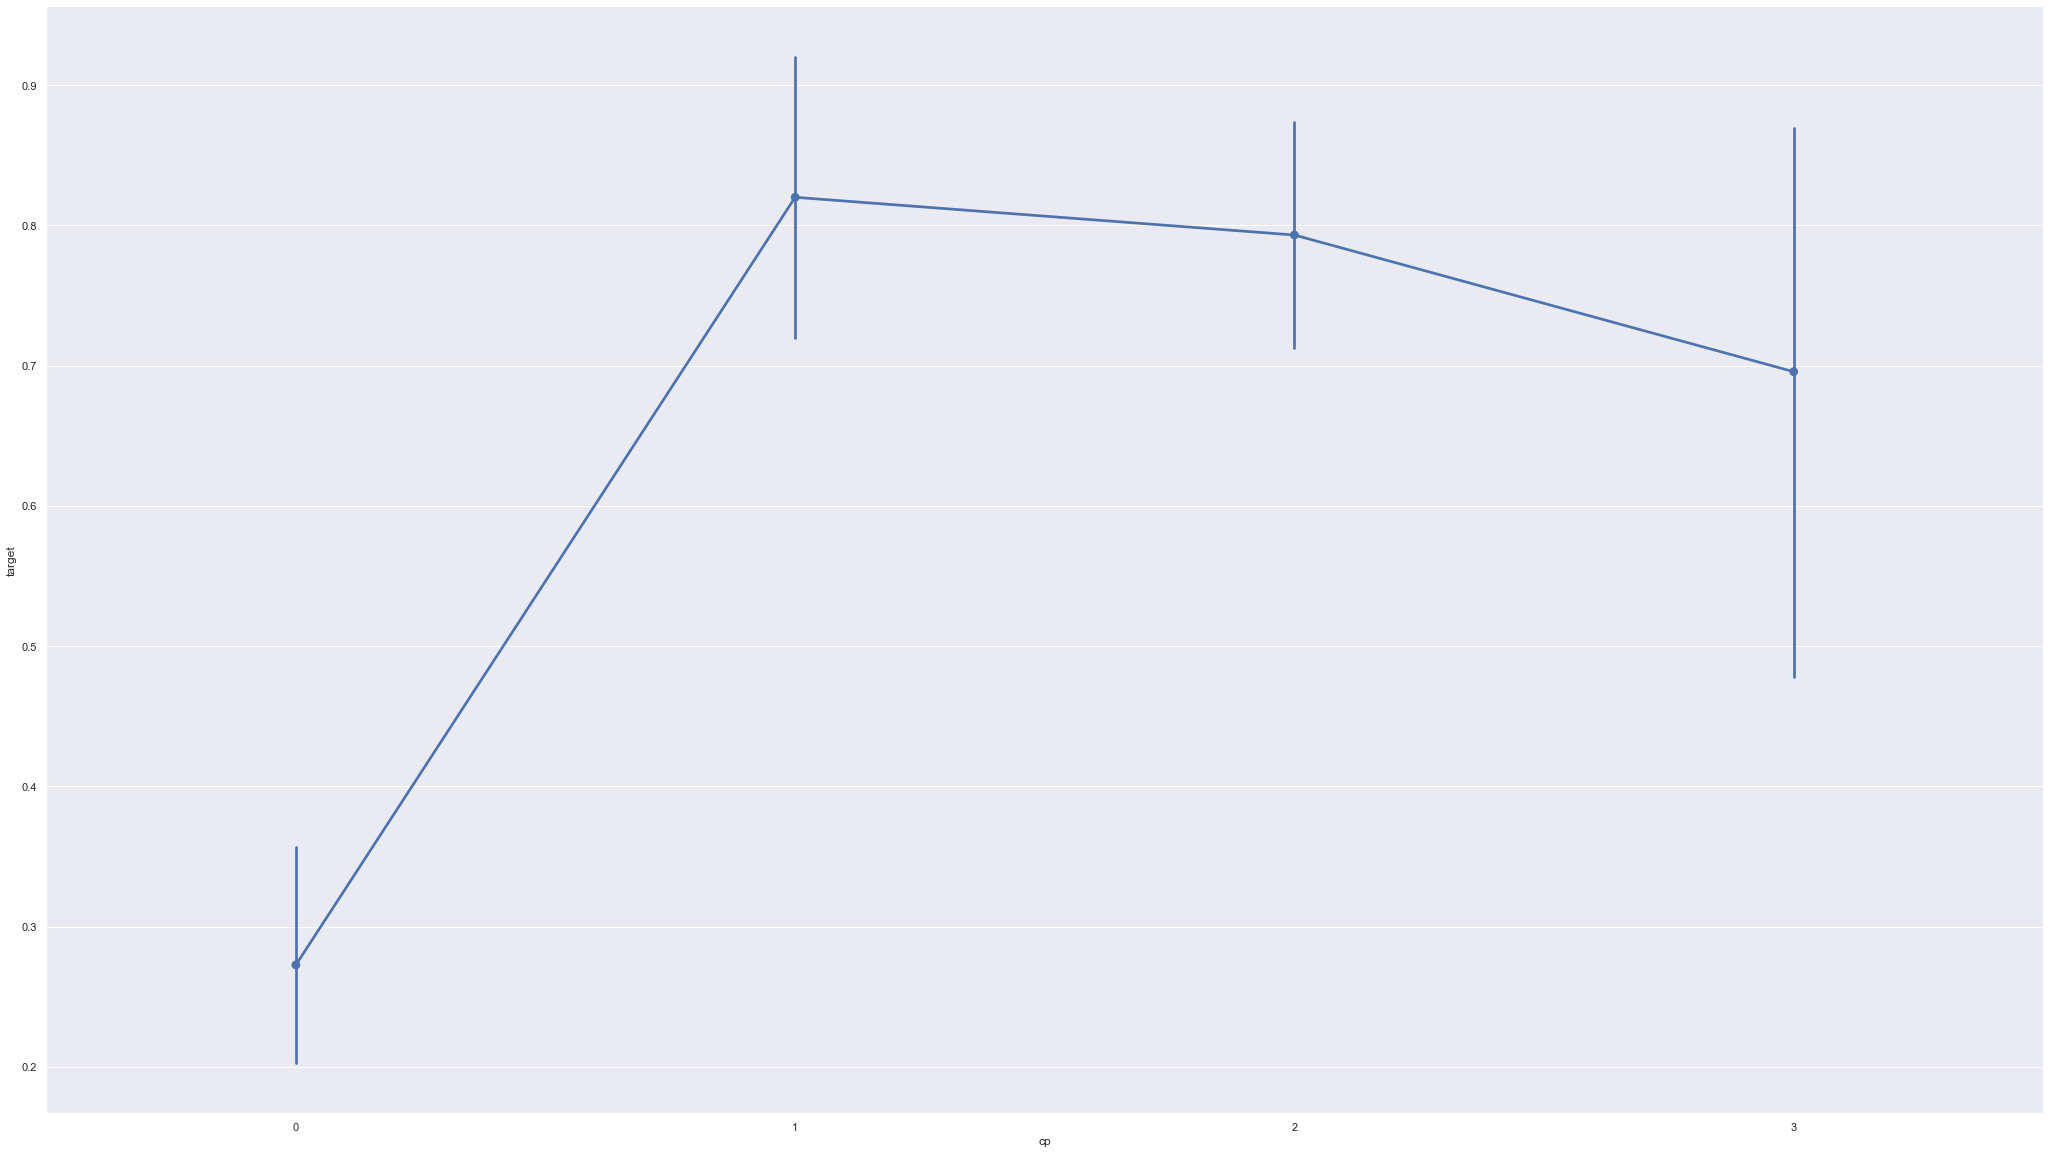

In [19]:
sns.catplot(x="cp", y="target", kind="point", data=heart_df, height=16, aspect= 16/9);

`cp` of type $3$ has a much wider 95% confidence interval than types $1$ and $2$, implying that chest pain of type $3$ is common in both target classes. Let us also explore the incidence rates.

In [20]:
pain_types = heart_df['cp'].unique()
for pain in pain_types:
    subset = heart_df[heart_df['cp'] == pain]
    incidence = subset[subset['target'] == 1].shape[0]/subset.shape[0]
    print("Incidence :: Pain Type", pain, "->", incidence)

Incidence :: Pain Type 3 -> 0.6956521739130435
Incidence :: Pain Type 2 -> 0.7931034482758621
Incidence :: Pain Type 1 -> 0.82
Incidence :: Pain Type 0 -> 0.2727272727272727


Quite clearly, the majority of people who report chest pain of types $1$, $2$ and $3$ have heart disease. This is an important feature in diagnosing the presence of heart disease.

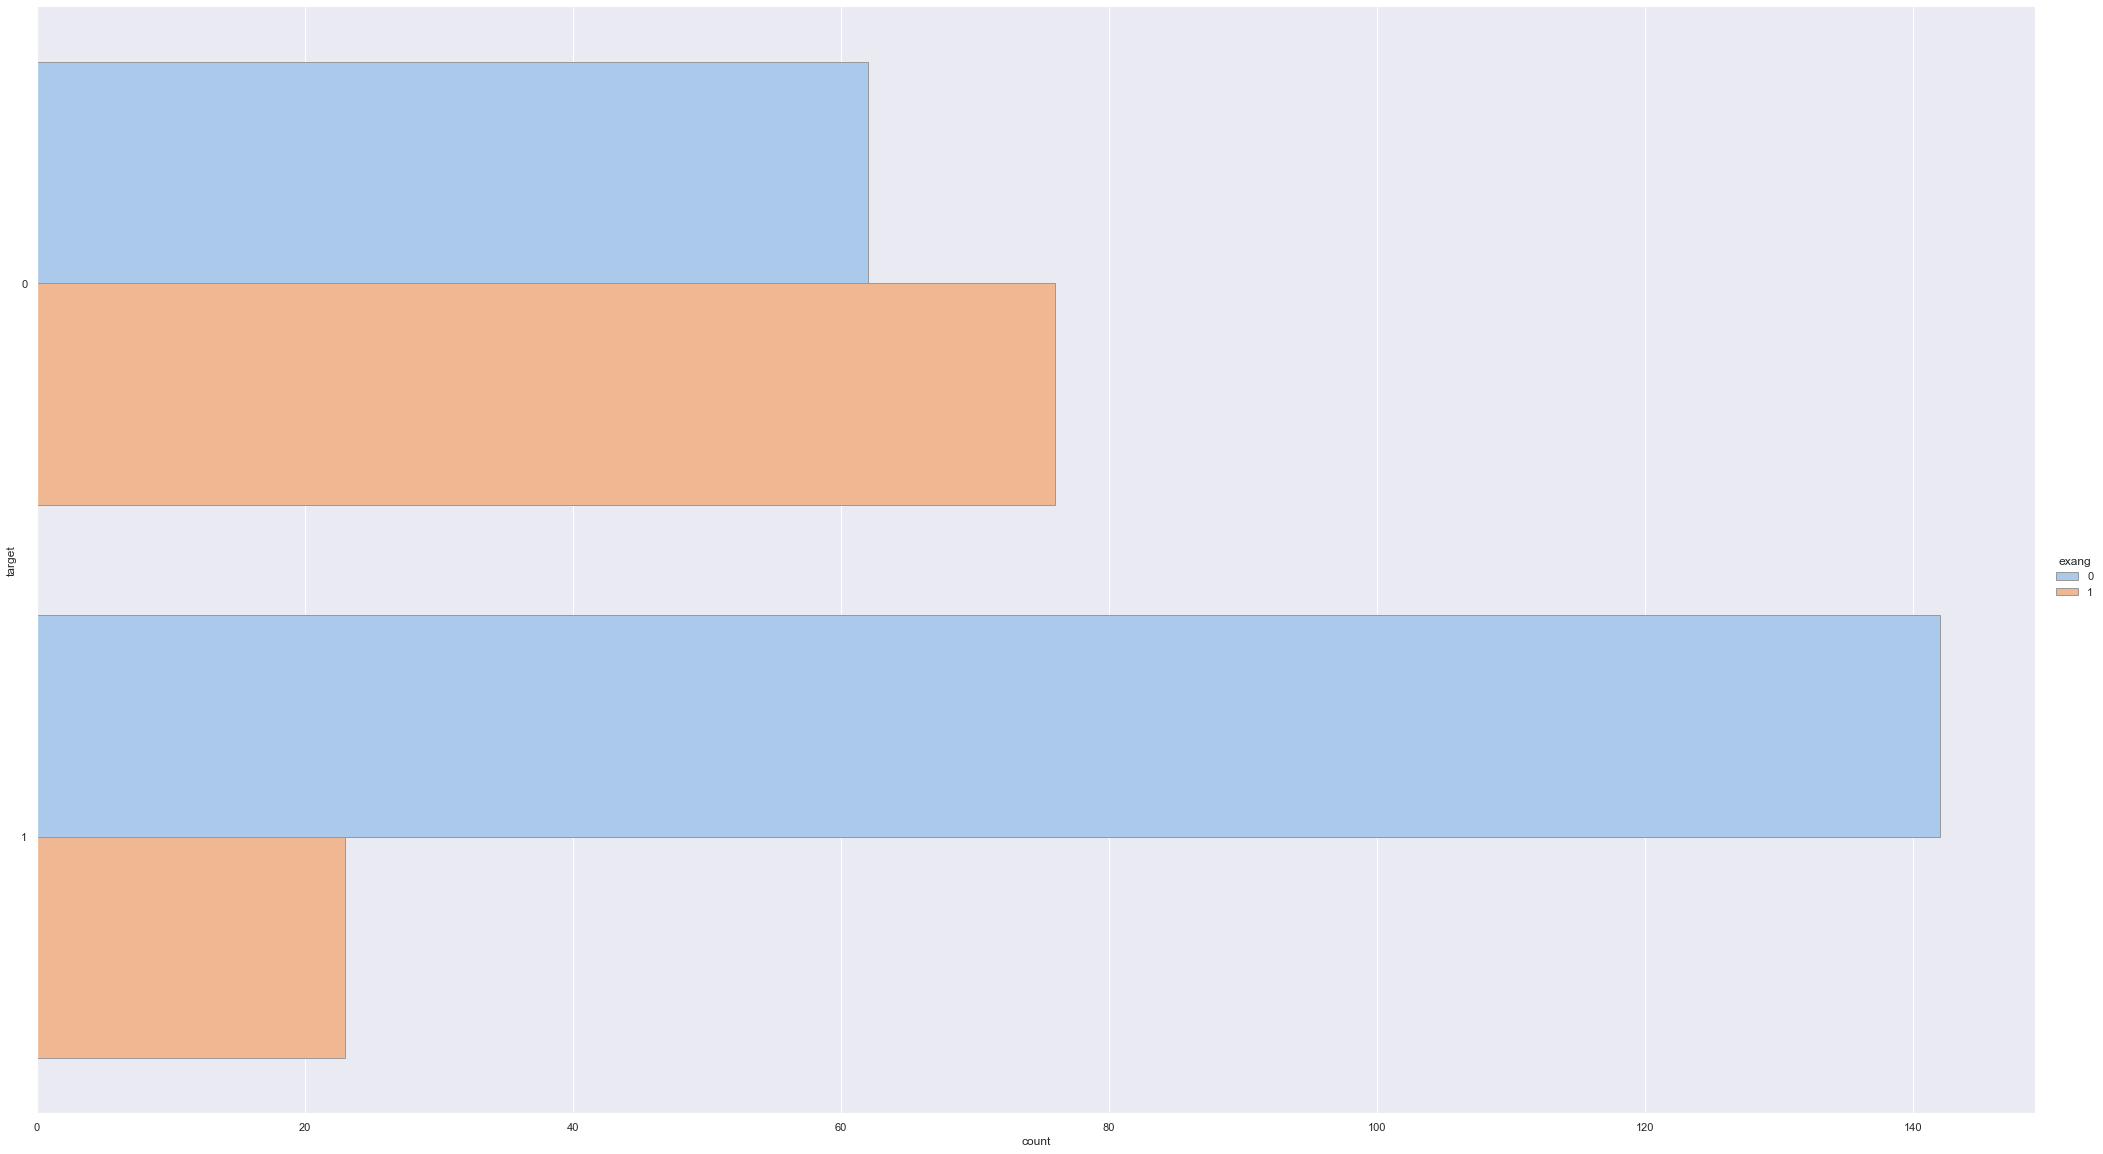

In [21]:
sns.catplot(y="target", hue="exang", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

People who report `exang` of type $1$ are much more likely to have heart disease than people who report `exang` of type $0$. In fact, let us look at the incidence rates to see which `exang` has a greater proportion of heart disease.

In [22]:
exang_types = heart_df['exang'].unique()
for exang in exang_types:
    subset = heart_df[heart_df['exang'] == exang]
    incidence = subset[subset['target'] == 1].shape[0]/subset.shape[0]
    print("Incidence :: Exang Type", exang, "->", incidence)

Incidence :: Exang Type 0 -> 0.696078431372549
Incidence :: Exang Type 1 -> 0.23232323232323232


Almost $70$% of people reporting `exang == 1` have heart disease in contrast to `exang == 0` where $23$% of people have heart disease.

Let's now explore ECG results (`restecg`) and heart rate (`thalach`)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.


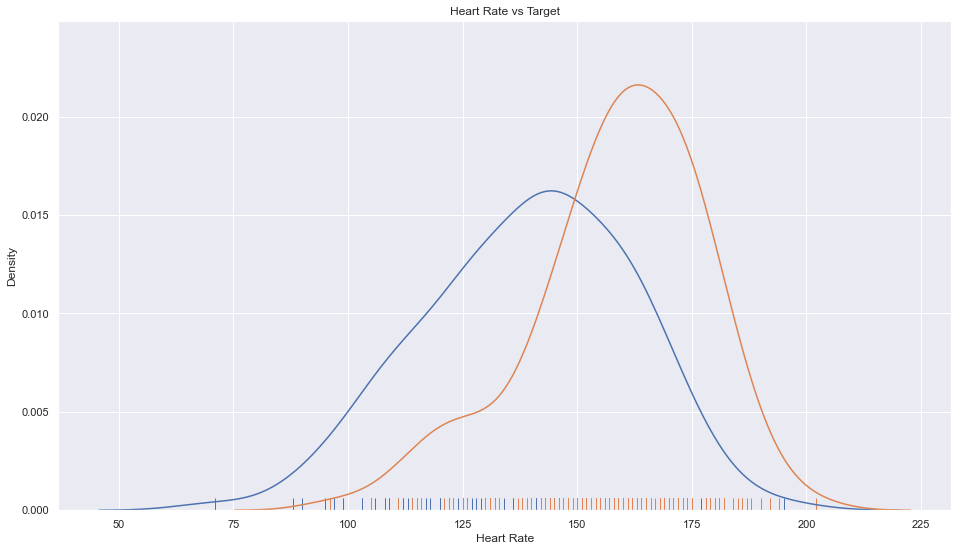

In [23]:
sns.distplot(df_hd0['thalach'], hist=False, rug=True, label = 'Without Heart Disease')
sns.distplot(df_hd1['thalach'], hist=False, rug=True, label = 'With Heart Disease')
plt.title('Heart Rate vs Target')
plt.xlabel('Heart Rate')
plt.ylabel('Density');

It is quite obvious from the plot here that having a higher heart rate indicates a higher likelihood of having heart disease. At lower heart rates, the likelihood of not having heart disease is higher, whereas at higher heart rates, the likelihood of having heart disease is higher. This is an important feature in diagnosing the presence of heart disease.

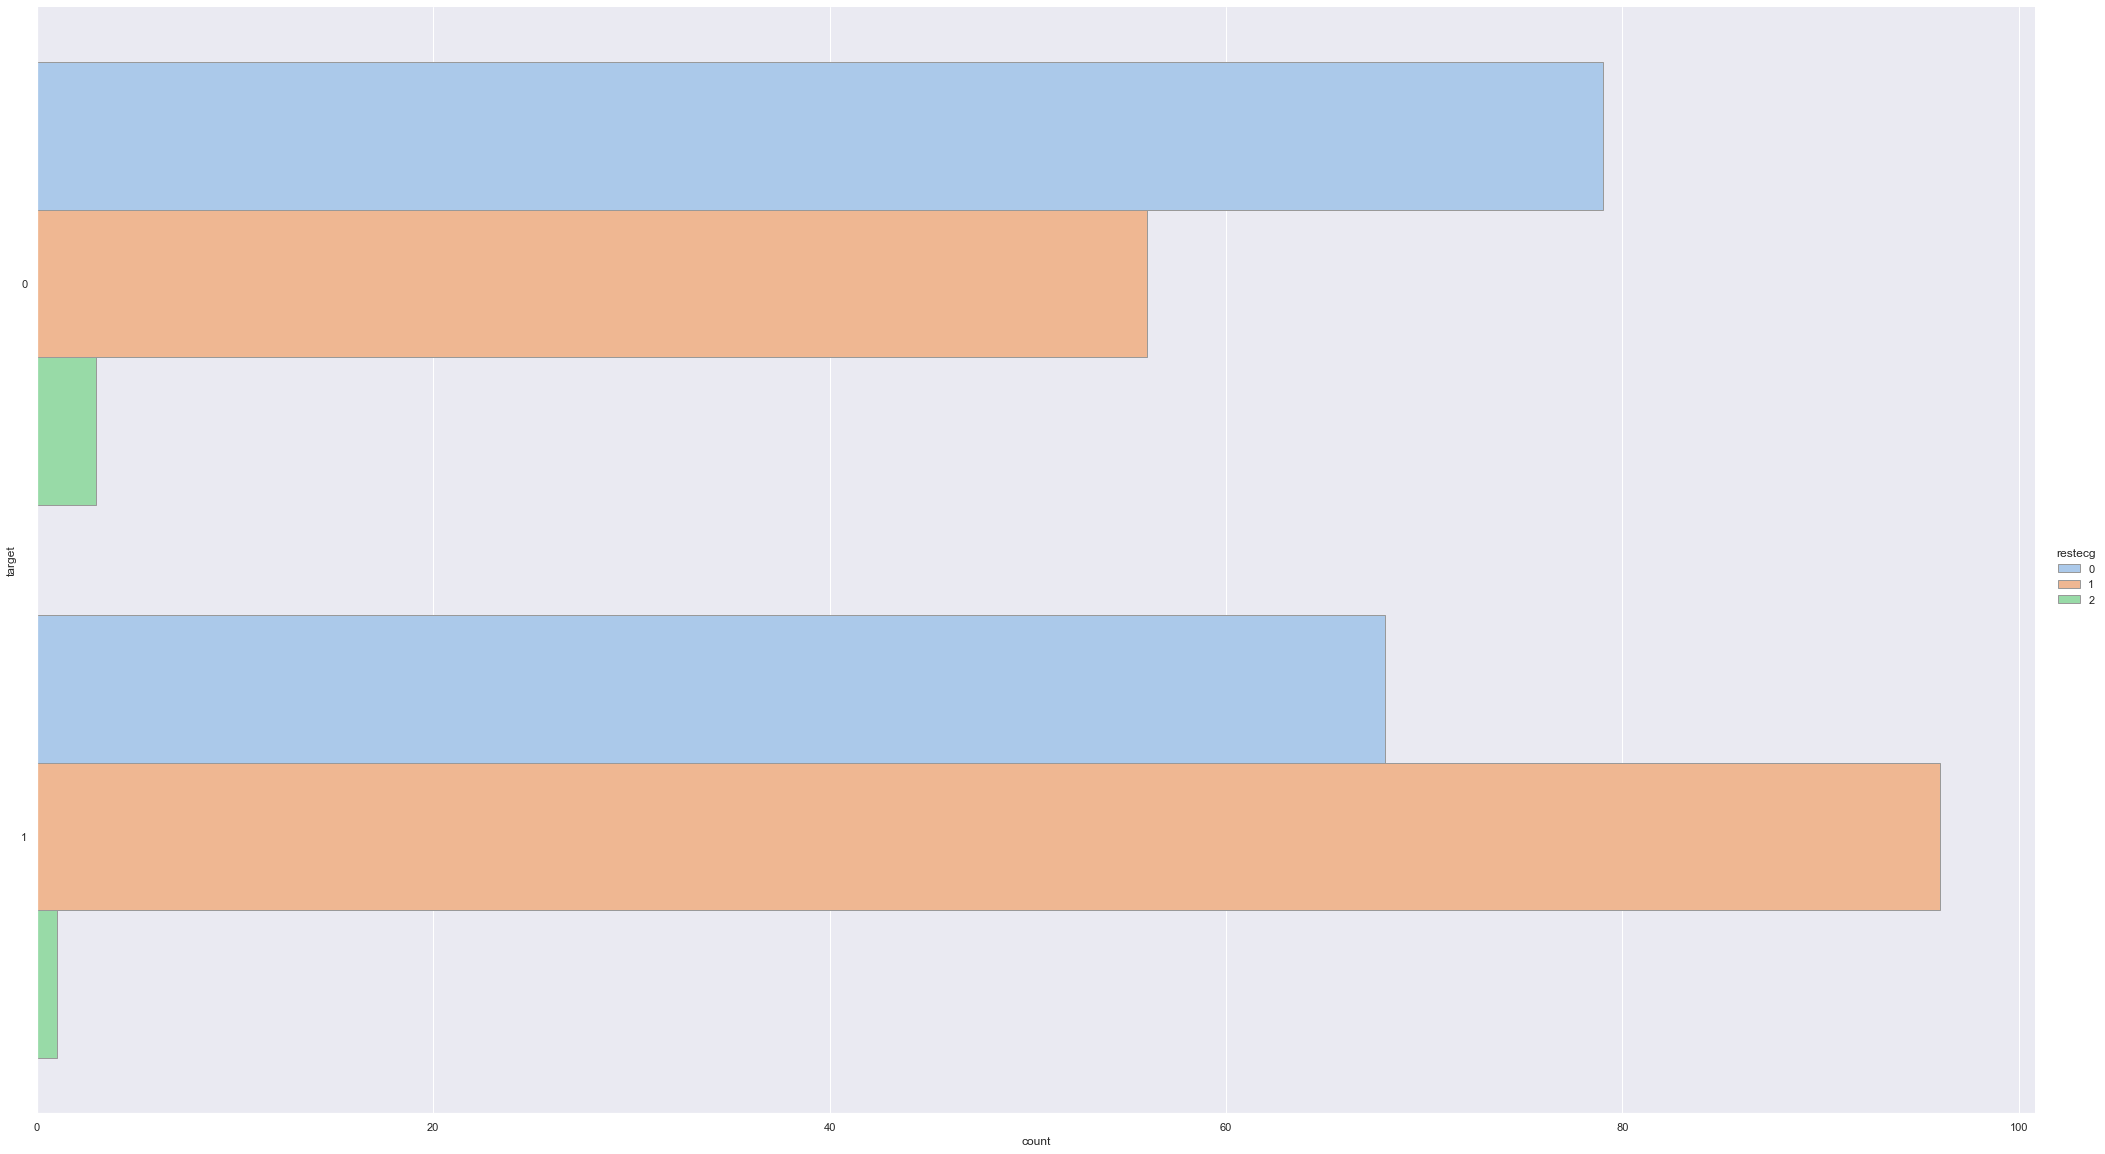

In [24]:
sns.catplot(y="target", hue="restecg", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df)

The incidence of heart disease amongst people who report `restecg == 1` seems to be higher than those subpopulations reporting other ecg types. Let's confirm this - 

In [25]:
ecg_types = heart_df['restecg'].unique()
for ecg in ecg_types:
    subset = heart_df[heart_df['restecg'] == ecg]
    incidence = subset[subset['target'] == 1].shape[0]/subset.shape[0]
    print("Incidence :: ECG Type", ecg, "->", incidence)

Incidence :: ECG Type 0 -> 0.46258503401360546
Incidence :: ECG Type 1 -> 0.631578947368421
Incidence :: ECG Type 2 -> 0.25


Let's look at `slope` and `thal`, the other categorical variables.

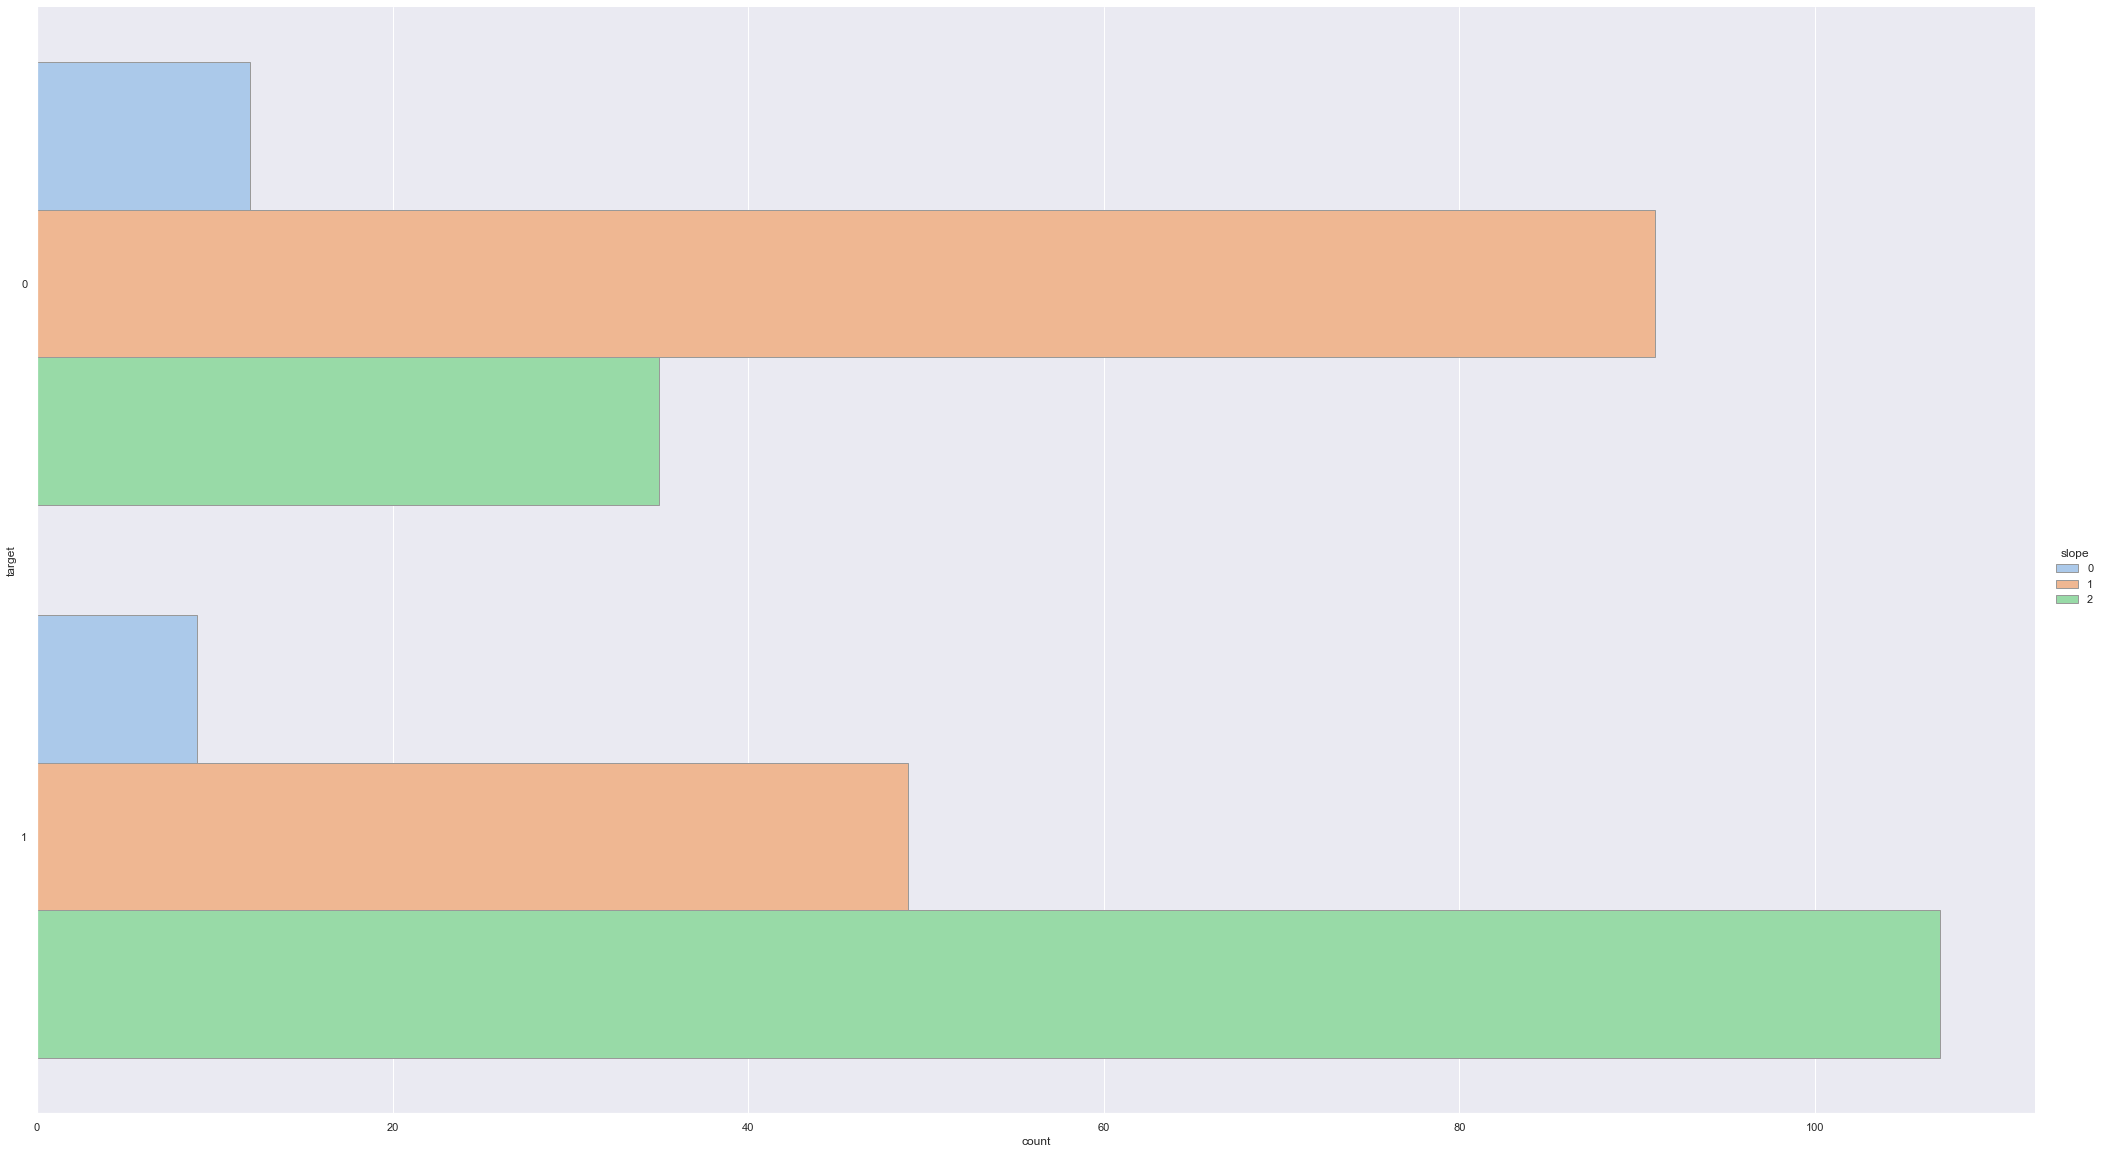

In [26]:
sns.catplot(y="target", hue="slope", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

Quite clearly, `slope` of type $2$, is more prevalent among the sub-population of people who do have heart disease. Similarly, `slope` of type $1$ is more prevalent among the sub-population of people who do not have heart disease.

In [27]:
slope_types = heart_df['slope'].unique()
for slope in slope_types:
    subset = heart_df[heart_df['slope'] == slope]
    incidence = subset[subset['target'] == 1].shape[0]/subset.shape[0]
    print("Incidence :: Slope Type", slope, "->", incidence)

Incidence :: Slope Type 0 -> 0.42857142857142855
Incidence :: Slope Type 2 -> 0.7535211267605634
Incidence :: Slope Type 1 -> 0.35


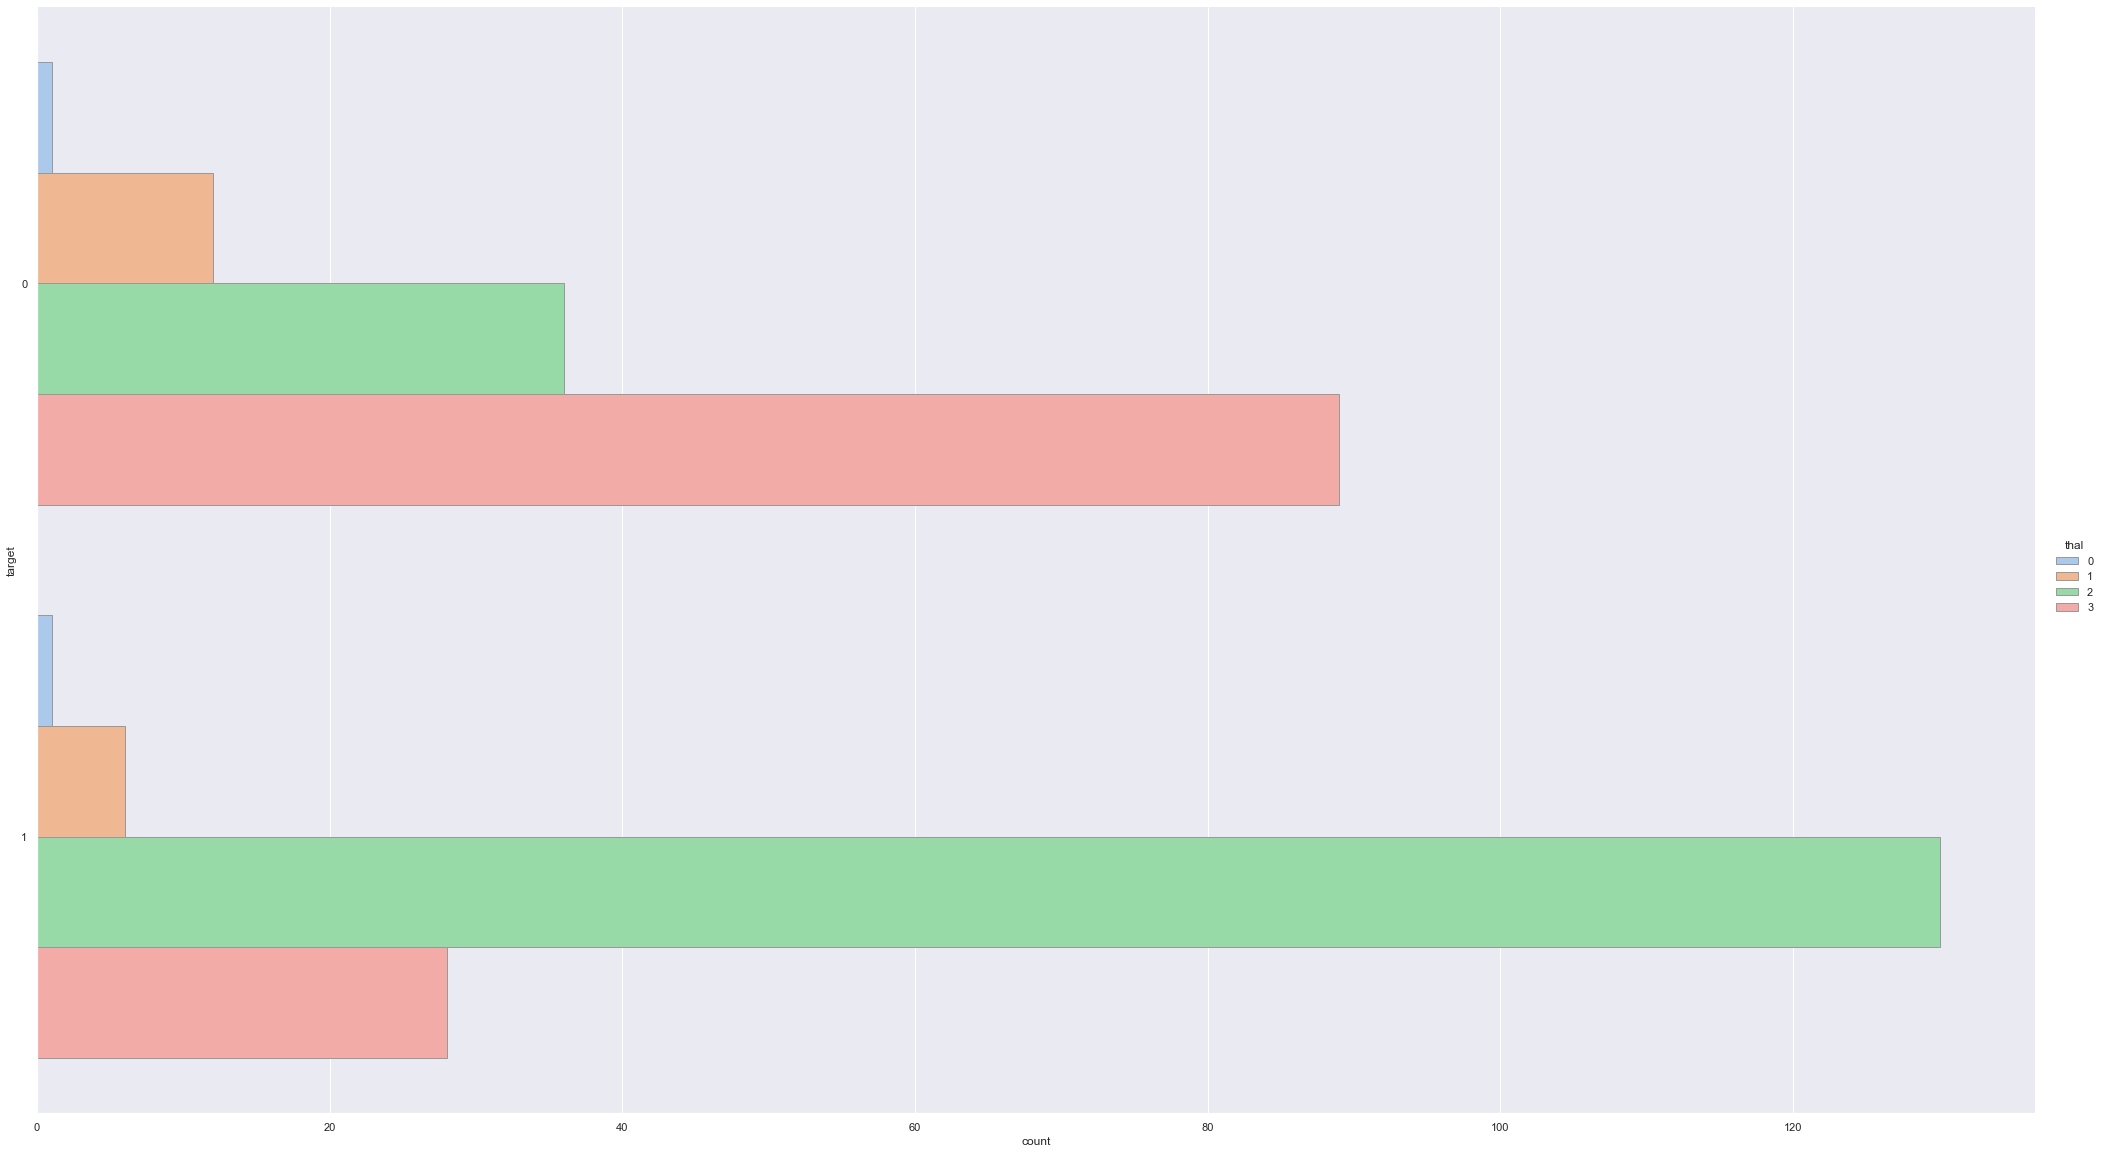

In [28]:
sns.catplot(y="target", hue="thal", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

Quite clearly, `thal` of type $2$, is more prevalent among the sub-population of people who do have heart disease. Similarly, `thal` of type $3$ is more prevalent among the sub-population of people who do not have heart disease.

In [29]:
thal_types = heart_df['thal'].unique()
for thal in thal_types:
    subset = heart_df[heart_df['thal'] == thal]
    incidence = subset[subset['target'] == 1].shape[0]/subset.shape[0]
    print("Incidence :: Thal Type", thal, "->", incidence)

Incidence :: Thal Type 1 -> 0.3333333333333333
Incidence :: Thal Type 2 -> 0.7831325301204819
Incidence :: Thal Type 3 -> 0.23931623931623933
Incidence :: Thal Type 0 -> 0.5


Lastly, let's examine `oldpeak` and `ca`, 2 continuous variables.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.


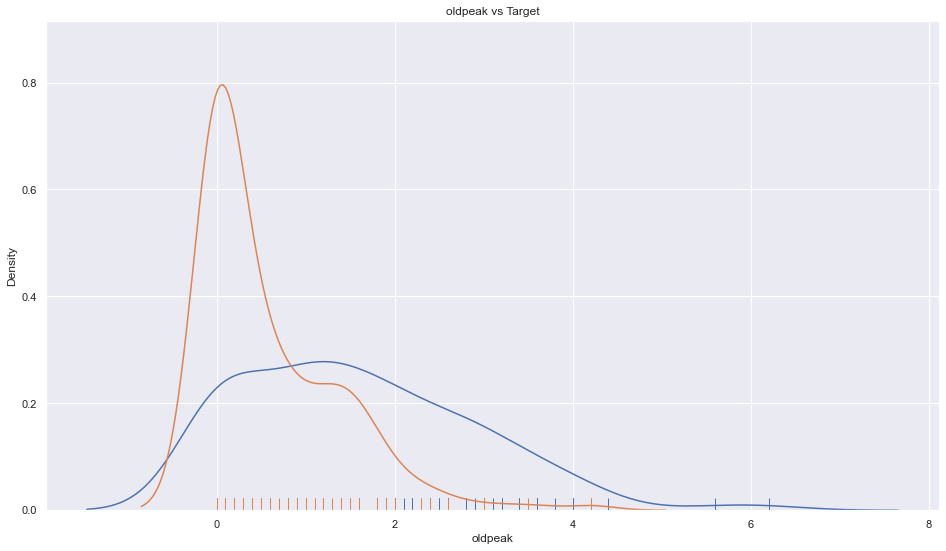

In [30]:
sns.distplot(df_hd0['oldpeak'], hist=False, rug=True, label = 'Without Heart Disease')
sns.distplot(df_hd1['oldpeak'], hist=False, rug=True, label = 'With Heart Disease')
plt.title('oldpeak vs Target')
plt.xlabel('oldpeak')
plt.ylabel('Density');

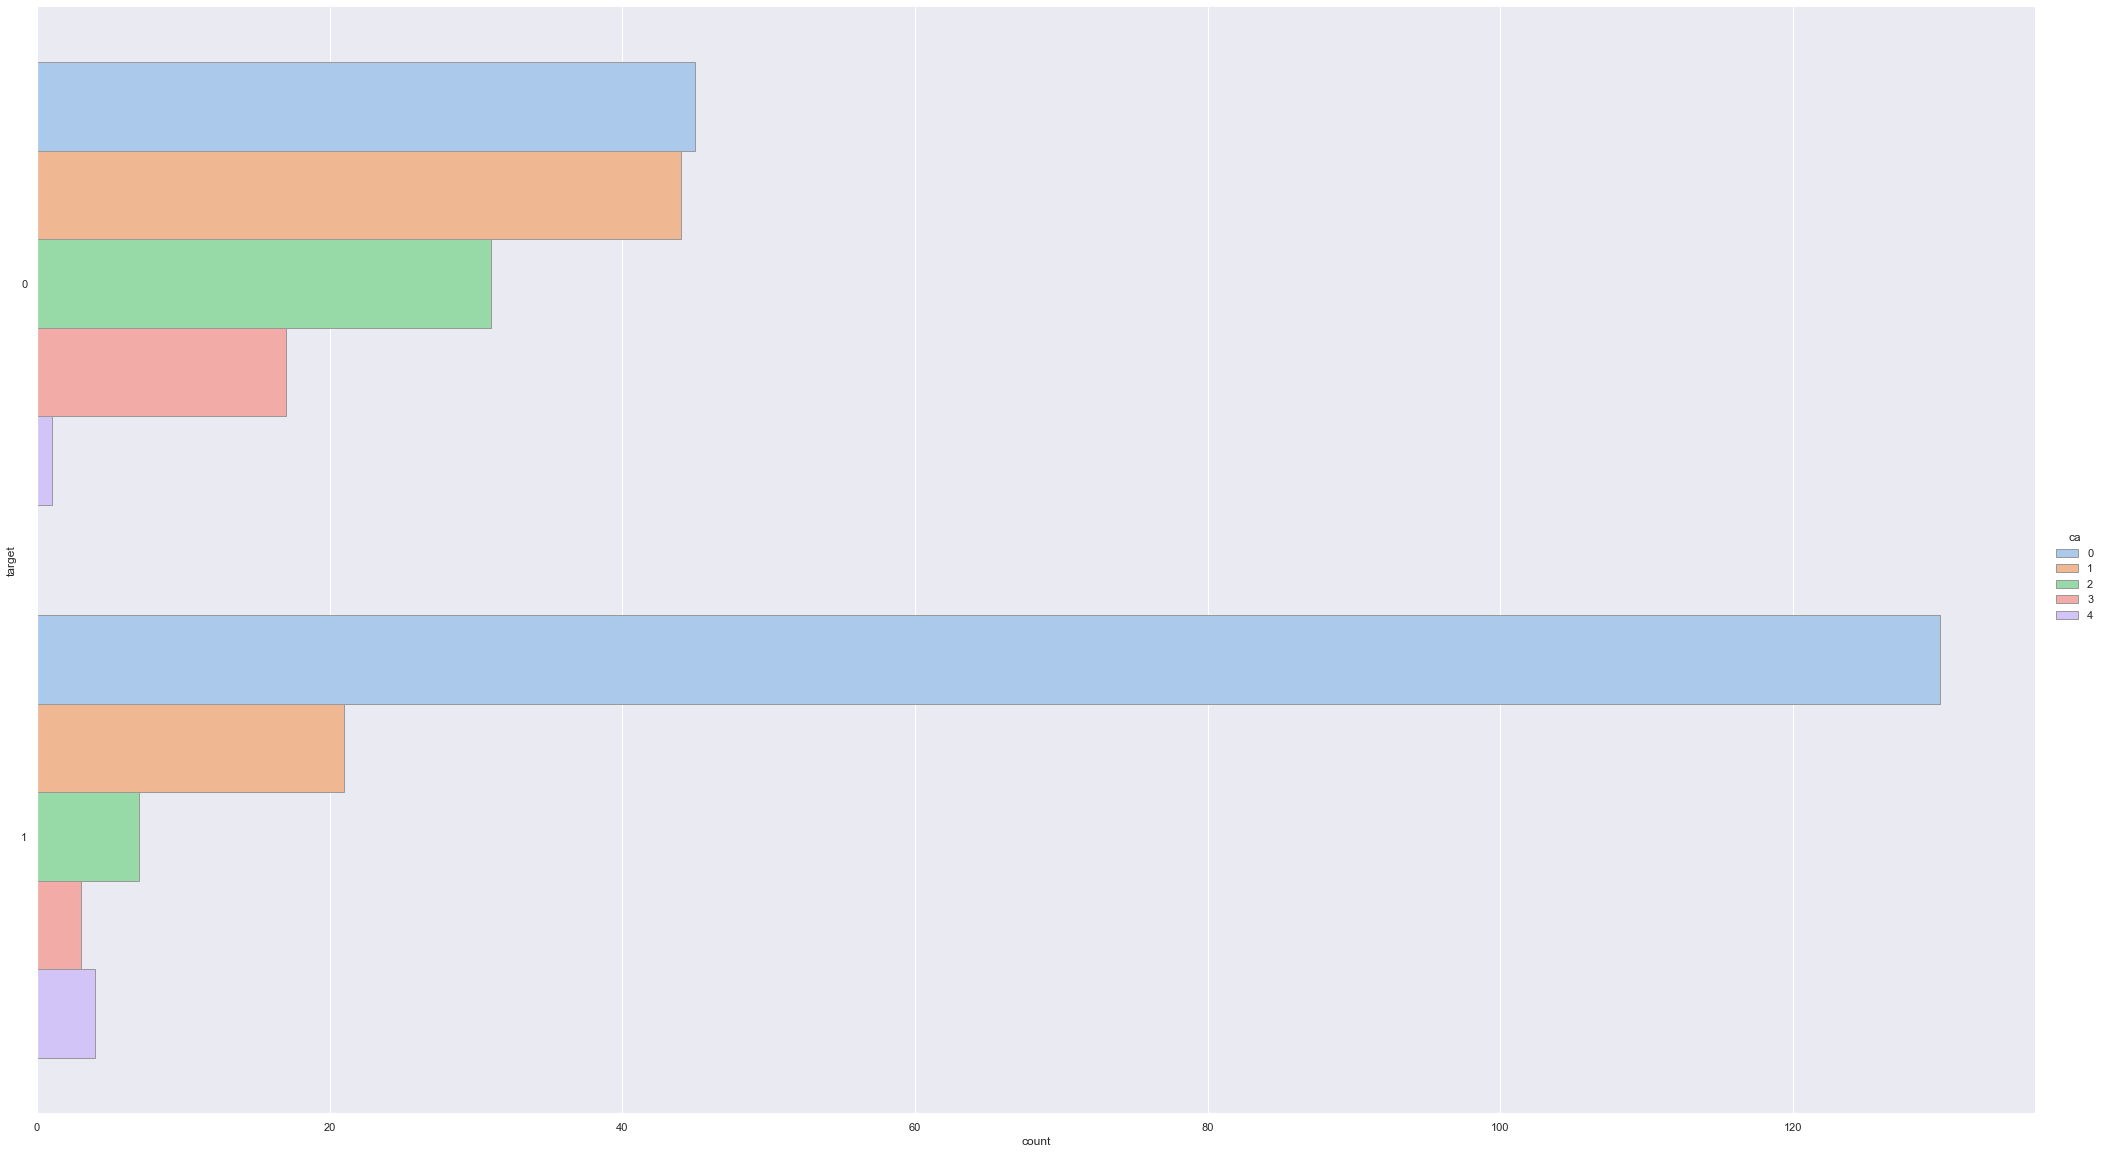

In [31]:
sns.catplot(y="target", hue="ca", kind="count",
            palette="pastel", edgecolor=".6",
            height=16, aspect= 16/9,
            data=heart_df);

In [32]:
ca_types = heart_df['ca'].unique()
for ca in ca_types:
    subset = heart_df[heart_df['ca'] == ca]
    incidence = subset[subset['target'] == 1].shape[0]/subset.shape[0]
    print("Incidence :: Number of Colored Arteries", ca, "->", incidence)

Incidence :: Number of Colored Arteries 0 -> 0.7428571428571429
Incidence :: Number of Colored Arteries 2 -> 0.18421052631578946
Incidence :: Number of Colored Arteries 1 -> 0.3230769230769231
Incidence :: Number of Colored Arteries 3 -> 0.15
Incidence :: Number of Colored Arteries 4 -> 0.8


## Data Pre-Processing

### Handling Missing Data

<AxesSubplot:>

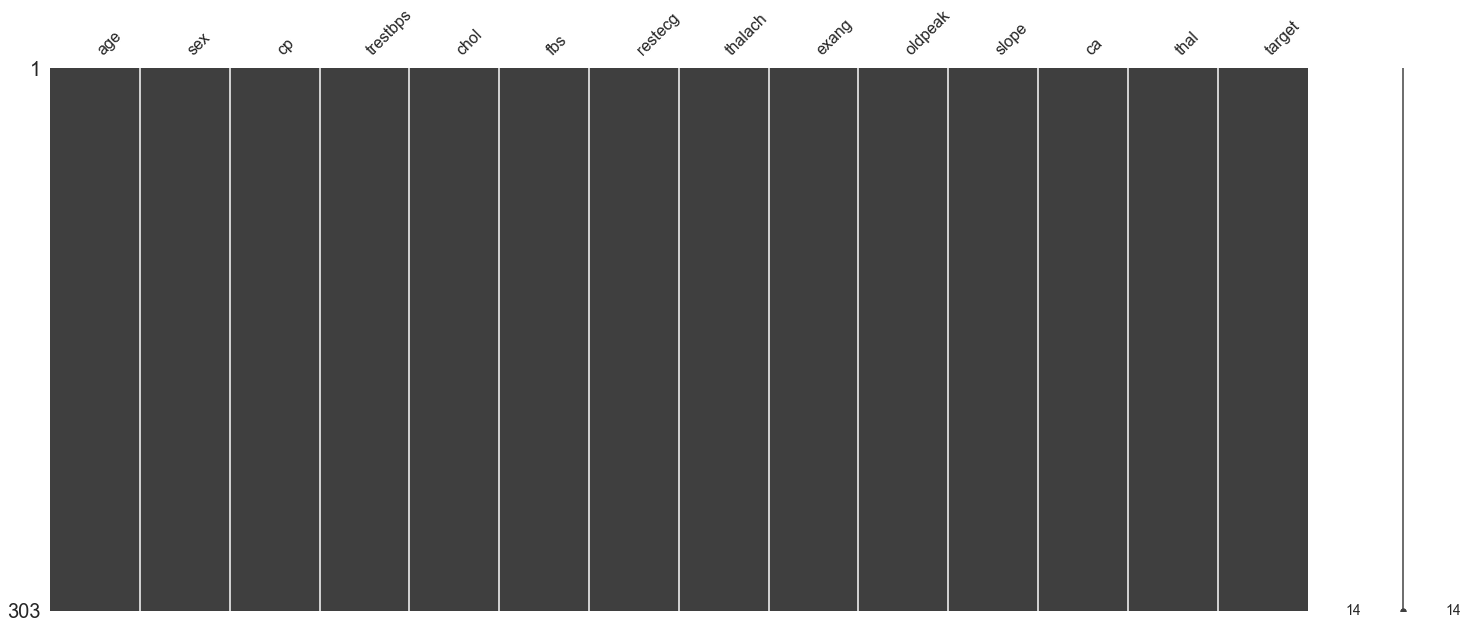

In [33]:
import missingno as msno
msno.matrix(heart_df)

Our dataset does not have any missing values, we do not have to handle missing data. We have some categorical variables, but since they are already encoded as numeric, we simply need to create dummy variables from them. Specifically dummy variables for these categorical variables - 
 *  `cp`
 *  `slope`
 
`ca` is not a categorical variable since it contains number of colored arteries, it simply has a small range (0-3)
`thal` and `restecg` are numeric ordinal.

### X and y split

In [34]:
X = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1].values

### Creating Dummy Variables

In [35]:
categorical = ['cp', 'slope']
X_new = pd.get_dummies(data=X,columns=categorical)
X_new.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'ca', 'thal', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'slope_0',
       'slope_1', 'slope_2'],
      dtype='object')

### Train-Test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_new.values, y, 
                                                    test_size = 0.25, random_state = 0)

In [37]:
print(X_train.shape)

(227, 18)


In [38]:
print(y_train.shape)

(227,)


### Feature Scaling

In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
print(X_train.shape)

(227, 18)


In [41]:
print(X_test.shape)

(76, 18)


## Fitting the Logistic Regression Model

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
# log_reg = LogisticRegression(random_state=0, class_weight = {0:.45, 1:.55}) ## With class_weights
log_reg = LogisticRegression(random_state=0) ## Without class_weights
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred = log_reg.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1], dtype=int64)

In [45]:
y_test

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int64)

In [46]:
predicted_probabilities = log_reg.predict_proba(X_test)
predicted_probabilities[:, 1] ## Probability of having target == 1

array([0.0822, 0.6994, 0.6859, 0.0167, 0.1107, 0.276 , 0.0625, 0.0754,
       0.012 , 0.0034, 0.7785, 0.9448, 0.0258, 0.8701, 0.9742, 0.7126,
       0.055 , 0.7213, 0.0068, 0.8629, 0.7625, 0.2165, 0.1121, 0.1162,
       0.906 , 0.692 , 0.1625, 0.3361, 0.9842, 0.7483, 0.653 , 0.0099,
       0.9812, 0.7413, 0.94  , 0.6626, 0.0477, 0.8628, 0.0502, 0.3026,
       0.6762, 0.8422, 0.4604, 0.0608, 0.5788, 0.8019, 0.7889, 0.5723,
       0.0428, 0.8301, 0.8705, 0.8398, 0.9859, 0.8716, 0.9972, 0.0863,
       0.9619, 0.9488, 0.7947, 0.9779, 0.7762, 0.9888, 0.9427, 0.9077,
       0.799 , 0.7462, 0.7983, 0.1543, 0.7126, 0.5498, 0.307 , 0.9516,
       0.9201, 0.0281, 0.0781, 0.9196])

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("CONFUSION MATRIX \n", cm)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY :", round(acc, 2))
precision = precision_score(y_test, y_pred)
print("PRECISION :", round(precision, 2))
recall = recall_score(y_test, y_pred)
print("RECALL :", round(recall, 2))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
print("AUC : ", round(auc_score, 2))

CONFUSION MATRIX 
 [[24  9]
 [ 4 39]]
ACCURACY : 0.83
PRECISION : 0.81
RECALL : 0.91
AUC :  0.82


Our logistic regression model, performs quite well on this test dataset. As we are diagnosing heart disease, it is critically important to reduce False Negatives (i.e. Predicting an absence of the disease when in reality there is heart disease) => we must **maximize** recall.

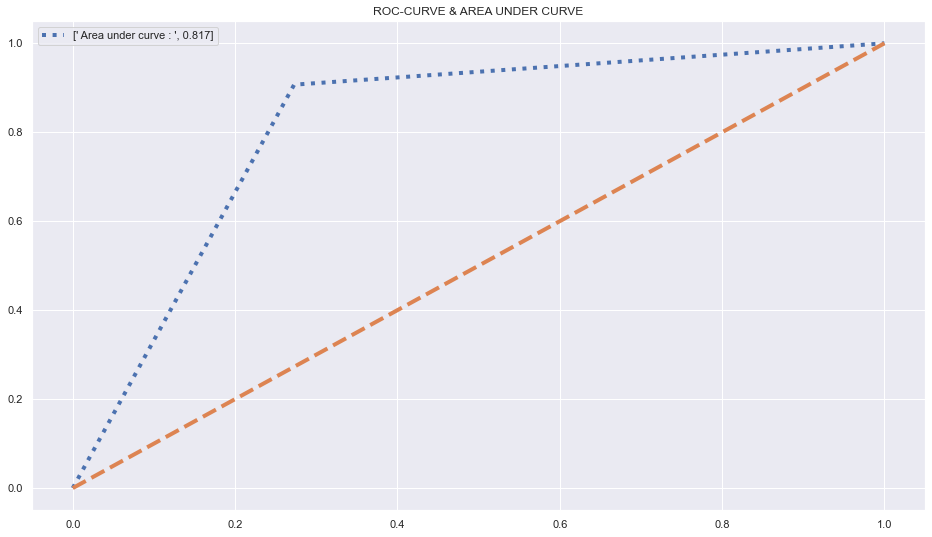

In [48]:
fig = plt.figure(figsize=(16, 9))
ax  = fig.add_subplot(111)
ax.plot(fpr, tpr, label = [" Area under curve : ", round(auc_score, 3)], linewidth = 4, linestyle = "dotted")
ax.plot([0,1],[0,1],linewidth = 4, linestyle = "dashed")
plt.legend(loc = "best")
plt.title("ROC-CURVE & AREA UNDER CURVE");

In [49]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_new, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.893505 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.867525 (0.103424) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.863235 (0.105305) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.873652 (0.098396) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.869608 (0.101650) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.859314 (0.107915) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.867647 (0.103221) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.877574 (0.088989) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.871446 (0.103227) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.881495 (0.099227) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.893505 (0.074970) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.893260 (0.084444) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.891176 (0.087139) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.834559 (0.102994) wit

## Fitting a Decision Tree Model

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
# dtree = DecisionTreeClassifier(random_state=0, class_weight = {0:.45, 1:.55}) ## With class_weights
dtree = DecisionTreeClassifier(random_state=0) ## Without class_weights
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [52]:
y_pred = dtree.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int64)

In [53]:
predicted_probabilities = dtree.predict_proba(X_test)
predicted_probabilities[:, 1] ## Probability of having target == 1

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 0.])

In [54]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("CONFUSION MATRIX \n", cm)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY :", round(acc, 2))
precision = precision_score(y_test, y_pred)
print("PRECISION :", round(precision, 2))
recall = recall_score(y_test, y_pred)
print("RECALL :", round(recall, 2))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
print("AUC : ", round(auc_score, 2))

CONFUSION MATRIX 
 [[26  7]
 [ 8 35]]
ACCURACY : 0.8
PRECISION : 0.83
RECALL : 0.81
AUC :  0.8


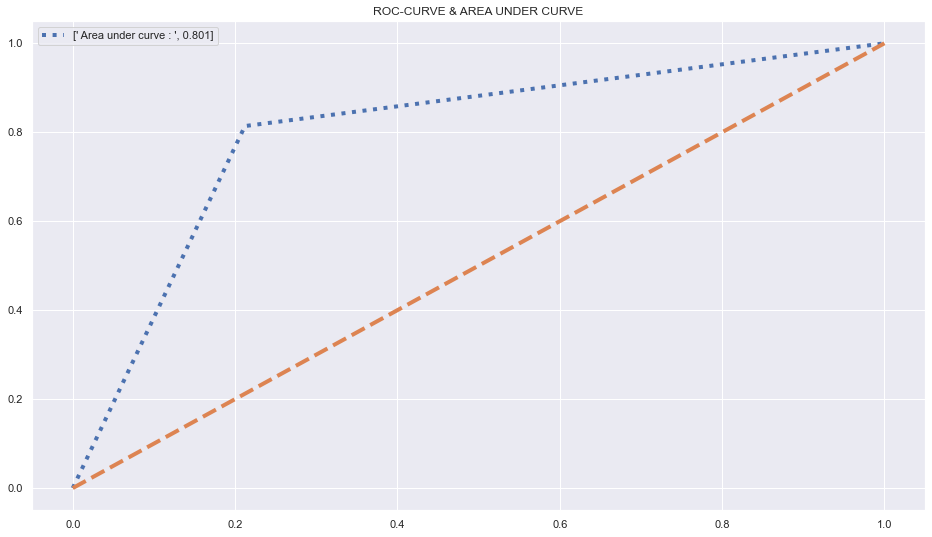

In [55]:
fig = plt.figure(figsize=(16, 9))
ax  = fig.add_subplot(111)
ax.plot(fpr, tpr, label = [" Area under curve : ", round(auc_score, 3)], linewidth = 4, linestyle = "dotted")
ax.plot([0,1],[0,1],linewidth = 4, linestyle = "dashed")
plt.legend(loc = "best")
plt.title("ROC-CURVE & AREA UNDER CURVE");

In [56]:
max_depth = [10, 20, 50]

# define grid search
grid = dict(max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=dtree, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_new, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.768873 using {'max_depth': 10}
0.768873 (0.111087) with: {'max_depth': 10}
0.762868 (0.112008) with: {'max_depth': 20}
0.762868 (0.112008) with: {'max_depth': 50}


## Fitting a Random Forest Model

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
# forest = RandomForestClassifier(random_state=0, class_weight = {0:.45, 1:.55}) ## With class_weights
forest = RandomForestClassifier(random_state=0) ## Without class_weights
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [59]:
y_pred = forest.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1], dtype=int64)

In [60]:
predicted_probabilities = forest.predict_proba(X_test)
predicted_probabilities[:, 1] ## Probability of having target == 1

array([0.21, 0.57, 0.57, 0.  , 0.15, 0.53, 0.14, 0.06, 0.07, 0.05, 0.54,
       0.96, 0.08, 0.98, 0.95, 0.62, 0.18, 0.85, 0.12, 0.6 , 0.88, 0.3 ,
       0.28, 0.2 , 0.79, 0.45, 0.23, 0.32, 0.91, 0.64, 0.57, 0.19, 0.97,
       0.78, 0.97, 0.47, 0.15, 0.93, 0.1 , 0.32, 0.73, 0.49, 0.9 , 0.14,
       0.47, 0.74, 0.87, 0.41, 0.1 , 0.74, 0.89, 0.69, 0.95, 0.72, 0.92,
       0.15, 0.75, 0.66, 0.77, 0.98, 0.8 , 1.  , 0.62, 0.89, 0.69, 0.67,
       0.65, 0.17, 0.73, 0.88, 0.45, 0.97, 0.86, 0.02, 0.15, 0.67])

In [61]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("CONFUSION MATRIX \n", cm)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY :", round(acc, 2))
precision = precision_score(y_test, y_pred)
print("PRECISION :", round(precision, 2))
recall = recall_score(y_test, y_pred)
print("RECALL :", round(recall, 2))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
print("AUC : ", round(auc_score, 2))

CONFUSION MATRIX 
 [[26  7]
 [ 5 38]]
ACCURACY : 0.84
PRECISION : 0.84
RECALL : 0.88
AUC :  0.84


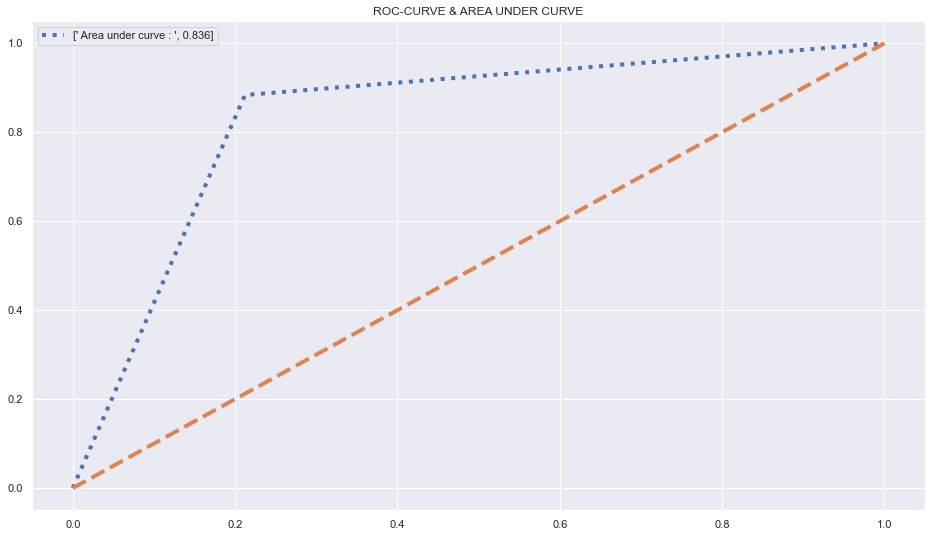

In [62]:
fig = plt.figure(figsize=(16, 9))
ax  = fig.add_subplot(111)
ax.plot(fpr, tpr, label = [" Area under curve : ", round(auc_score, 3)], linewidth = 4, linestyle = "dotted")
ax.plot([0,1],[0,1],linewidth = 4, linestyle = "dashed")
plt.legend(loc = "best")
plt.title("ROC-CURVE & AREA UNDER CURVE");

In [63]:
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=forest, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_new, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.867525 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.809804 (0.116662) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.851225 (0.087521) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.867525 (0.082446) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.809804 (0.116662) with: {'max_features': 'log2', 'n_estimators': 10}
0.851225 (0.087521) with: {'max_features': 'log2', 'n_estimators': 100}
0.867525 (0.082446) with: {'max_features': 'log2', 'n_estimators': 1000}


In [64]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_new)

print(shap_values[0][0,:])
print(X_train[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_new.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


[ 0.003   0.0352  0.0422 -0.0013 -0.0023 -0.0124 -0.0392 -0.0301  0.0749
  0.103   0.0675 -0.0655  0.0005  0.0058  0.0053  0.0039 -0.0328  0.0196]
[ 0.3526  0.7024  0.0202 -0.436  -0.427  -0.9826  1.0119 -0.7235  1.7248
  1.2272  1.1214 -0.9696 -0.4197  1.5959 -0.3022 -0.2754 -0.9114  1.0497]


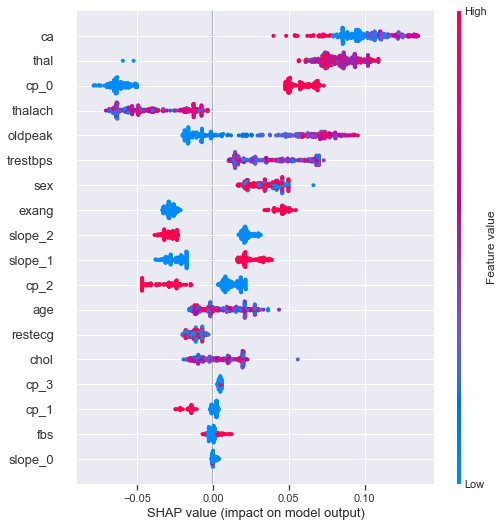

In [65]:
shap.summary_plot(shap_values[0], X_new)

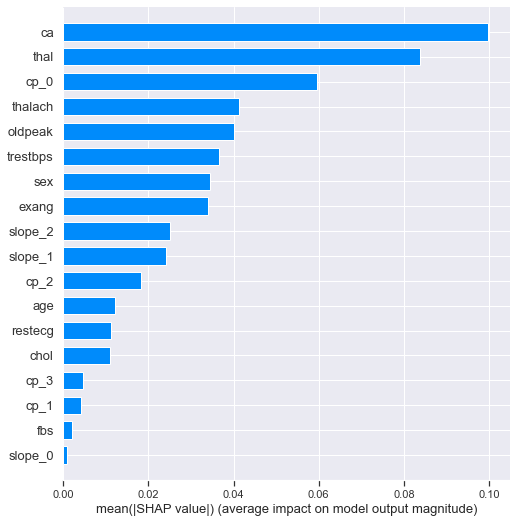

In [66]:
shap.summary_plot(shap_values[0], X_new, plot_type="bar")

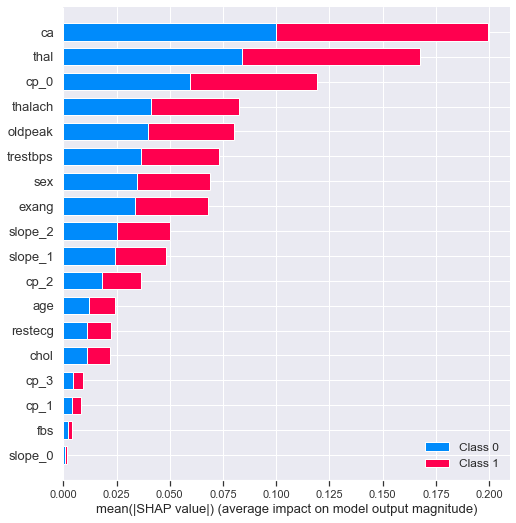

In [67]:
shap.summary_plot(shap_values, X_new)

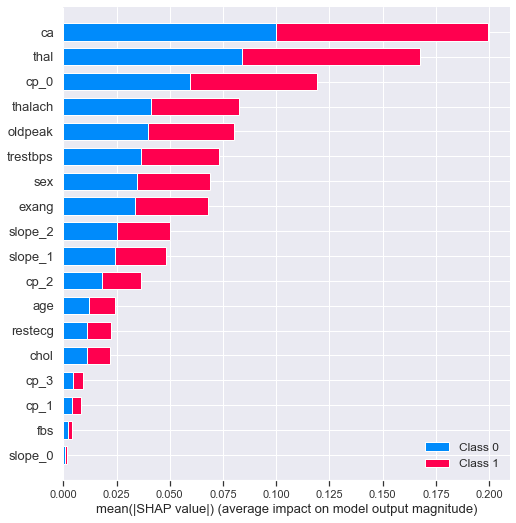

In [68]:
shap.summary_plot(shap_values, X_new, plot_type="bar")